In [1]:
import os
import numpy as np
import torch
import util
import matplotlib.pyplot as plt
from data import fr
from torch.autograd.gradcheck import zero_gradients
%matplotlib inline
from utils_project import compute_jacobian_and_bias,compute_bias, check_bias
from data.data import gen_signal
# three outputs from this function: signal [num_samples, 2, signal_dim]; frequency (float)[num_samples, num_freq];
# num_freq:int [num_samples] 
from data.noise import noise_torch
from data import fr
# find nearest
def find_neariest_idx(signal_fr, xgrid):
    indices = []
    for i in signal_fr:
        idx = np.argmin(np.abs(i - xgrid))
        indices.append(idx)
    return indices

# Load Model and verify that it's bias free

In [22]:
fr_path = 'checkpoint/model_snr_1_bias_no/fr/epoch_300.pth'
fc_path = 'checkpoint/model_snr_1_bias_no/fc/epoch_300.pth'
data_dir = 'test_dataset'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#load models
fr_module, _, _, _, _ = util.load(fr_path, 'fr', device)
fr_module.cpu()
fr_module.eval()
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)

In [3]:
#load data
f = np.load(os.path.join(data_dir, 'f.npy'))
signal_0dB = np.load(os.path.join(data_dir, '0.0dB.npy'))
signal_10dB = np.load(os.path.join(data_dir, '10.0dB.npy'))
signal_50dB = np.load(os.path.join(data_dir, '50.0dB.npy'))
nfreq = nfreq = np.sum(f >= -0.5, axis=1)
idx = 8
inp = torch.as_tensor(signal_10dB[idx][None])

In [4]:
jacobian, inputs, outputs = compute_jacobian_and_bias(inp, fr_module)
bias = compute_bias(jacobian, inputs, outputs)

In [5]:
fft_filter = jacobian[0] - 1j * jacobian[1]
bias = bias.reshape(-1)

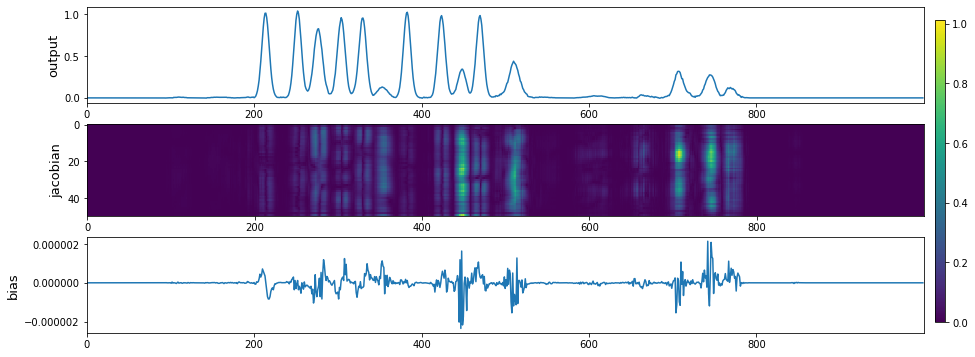

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6))

ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[0].set_xticklabels(np.arange(0, 1000, 200))
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylabel('output', fontsize=13)

im = ax[1].imshow(np.abs(fft_filter))
ax[1].set_aspect(2.2)
ax[1].set_ylabel('jacobian', fontsize=13)

ax[2].plot(xgrid, bias)
ax[2].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[2].set_xticklabels(np.arange(0, 1000, 200))
ax[2].set_xlim(-0.5, 0.5)
ax[2].set_ylabel('bias', fontsize=13)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

# Analysis

In [7]:
import matplotlib.backends.backend_pdf


In [10]:
def svd_jacobian(jacobian):
    fft_filter = jacobian[0]  - 1j * jacobian[1]
    fft_filter = fft_filter.T
    u, s, vh = np.linalg.svd(fft_filter)
    return u, s, vh

def generate_report_plots(num_samples=2, signal_dim=50, min_sep=1., snr=30, fixed_freq=[0.4], save=False):
    if not os.path.exists('./plots'):
        os.mkdir('./plots')
    save_dir = './plots'
    num_freq = len(fixed_freq)
    for signal_idx in range(num_samples):
        clean_signals, signal_frs, signal_num_freqs = gen_signal(num_samples=num_samples, 
                                                             signal_dim=signal_dim, 
                                                             num_freq=num_freq, min_sep=min_sep,
                                                            fixed_freq=fixed_freq)
        noisy_signals = noise_torch(torch.as_tensor(clean_signals), snr, 'gaussian')

        clean_signal, signal_fr, signal_num_freq = clean_signals[signal_idx], signal_frs[signal_idx], signal_num_freqs[signal_idx]
        noisy_signal = noisy_signals[signal_idx].cpu().numpy()
        clean_signal_t = clean_signal[0] + clean_signal[1] * 1j 
        clean_signal_fft = np.fft.fft(clean_signal_t, n=1000)
        clean_signal_fft = np.fft.fftshift(clean_signal_fft)
        noisy_signal_t = noisy_signal[0] + 1j * noisy_signal[1]
        noisy_signal_fft = np.fft.fft(noisy_signal_t, n=1000)
        noisy_signal_fft = np.fft.fftshift(noisy_signal_fft)
        if signal_idx == 0: # plot clean first
            noisy_signal = torch.as_tensor(clean_signal).unsqueeze(dim=0)
        else:
            noisy_signal = torch.as_tensor(noisy_signal).unsqueeze(dim=0)

        jacobian, inputs, outputs = compute_jacobian_and_bias(noisy_signal, fr_module)
        fft_filter = jacobian[0] - 1j * jacobian[1]
        
        
        # plot 1
        fig1, ax = plt.subplots(3, 1, figsize=(15, 6))
        xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
        ax[0].plot(xgrid, outputs[0])
        ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
        ylim = ax[0].get_ylim()
        for i in range(signal_fr.shape[0]):
            ax[0].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
        ax[0].legend()
        ax[0].set_xlim(-0.5, 0.5)
        ax[1].plot(xgrid, np.abs(clean_signal_fft),label='clean fft')
        ax[1].plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy fft')
        ax[1].set_xlim(-0.5, 0.5)
        ylim = ax[1].get_ylim()
        for i in range(signal_fr.shape[0]):
            ax[1].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
        ax[1].legend()
        im = ax[2].imshow(np.abs(fft_filter))
        ax[2].set_aspect(2.2)
        ax[2].set_ylabel('jacobian', fontsize=13)

        fig1.subplots_adjust(right=0.9)
        cbar_ax = fig1.add_axes([0.91, 0.15, 0.01, 0.7])
        fig1.colorbar(im, cax=cbar_ax)
        plt.show()
        # plot 2
        fig2, ax = plt.subplots(3, 1, figsize=(15, 6))
        xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
        ax[0].plot(xgrid, outputs[0])
        ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
        ylim = ax[0].get_ylim()
        for i in range(signal_fr.shape[0]):
            ax[0].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
        ax[0].legend()

        ax[1].plot(xgrid, np.abs(clean_signal_fft),label='clean fft')
        ax[1].plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy fft')
        ylim = ax[1].get_ylim()
        for i in range(signal_fr.shape[0]):
            ax[1].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
        ax[1].legend()
        fft_filter_norm = fft_filter * np.conjugate(fft_filter)
        fft_filter_norm = fft_filter_norm.T.sum(axis=1).real
        ax[2].plot(xgrid, fft_filter_norm)
        ax[0].set_xlim(-0.5, 0.5)
        ax[1].set_xlim(-0.5, 0.5)
        ax[2].set_xlim(-0.5, 0.5)

        fig2.subplots_adjust(right=0.9)
        plt.show()
        
        # plot. 3
        indices = find_neariest_idx(signal_fr, xgrid)
        target_filter = fft_filter.T[indices]
        # time domain
        fig3, ax = plt.subplots(target_filter.shape[0], 2)
        for idx, filt in enumerate(target_filter):
            if target_filter.shape[0] > 1:
                ax[idx, 0].plot(filt.real)
                ax[idx, 1].plot(filt.imag)
                ax[idx, 0].set_title('Real Part of Freq:{:4.2f};'.format(signal_fr[idx]))
                ax[idx, 1].set_title('Complex Part of Freq:{:4.2f};'.format(signal_fr[idx]))
            else:
                ax[0].plot(filt.real)
                ax[1].plot(filt.imag)
                ax[0].set_title('Real Part of Freq:{:4.2f};'.format(signal_fr[idx]))
                ax[1].set_title('Complex Part of Freq:{:4.2f};'.format(signal_fr[idx]))
        plt.tight_layout()
        plt.show()
        
        # fft domian of signals
        fig4, ax = plt.subplots(target_filter.shape[0], 1,  dpi=300)
        for idx, filt in enumerate(target_filter):
            filt_fft = np.fft.fft(filt,n=1000)
            filt_fft = np.fft.fftshift(filt_fft)
            magnitude = np.abs(filt_fft)
            if target_filter.shape[0] > 1:
                ax[idx].plot(xgrid, magnitude)
                ax[idx].plot(signal_fr[idx], magnitude[indices[idx]], '*')
                ax[idx].plot(-signal_fr[idx], magnitude[999-indices[idx]], '*')
                ax[idx].set_title('Freq:{:4.2f}'.format(signal_fr[idx]))
            else:
                ax.plot(xgrid, magnitude)
                ax.plot(signal_fr[idx], magnitude[indices[idx]], '*')
                ax.plot(-signal_fr[idx], magnitude[999-indices[idx]], '*')
                ax.set_title('Freq:{:4.2f}'.format(signal_fr[idx]))
        plt.tight_layout()
        plt.show()
        
        if save:
            file_name = 'output_clean_{}.pdf' if signal_idx == 0 else 'output_{}.pdf'
            pdf = matplotlib.backends.backend_pdf.PdfPages("./plots/" + file_name.format(signal_idx))
            pdf.savefig(fig1)            
            pdf.savefig(fig2)
            pdf.savefig(fig3)
            pdf.savefig(fig4)
            pdf.close()

In [35]:
# hyper parameter setting
num_samples=10
signal_dim=50
min_sep=1.
snr=1
#fixed_freq = [0.1,0.15, 0.2, 0.25, 0.3, 0.35, 0.4] # set None for  random frequency
fixed_freq = [0.4, 0.25]
num_freq=len(fixed_freq)

In [36]:
clean_signals, signal_frs, signal_num_freqs = gen_signal(num_samples=num_samples, 
                                                         signal_dim=signal_dim, 
                                                         num_freq=num_freq, min_sep=min_sep,
                                                        fixed_freq=fixed_freq)
noisy_signals = noise_torch(torch.as_tensor(clean_signals), snr, 'gaussian')
idx = 0


## Doing FFT on noisy/clean  signal

In [37]:
clean_signal, signal_fr, signal_num_freq = clean_signals[idx], signal_frs[idx], signal_num_freqs[idx]
noisy_signal = noisy_signals[idx].cpu().numpy()
clean_signal_t = clean_signal[0] + clean_signal[1] * 1j 
clean_signal_fft = np.fft.fft(clean_signal_t, n=1000)
clean_signal_fft = np.fft.fftshift(clean_signal_fft)
noisy_signal_t = noisy_signal[0] + 1j * noisy_signal[1]
noisy_signal_fft = np.fft.fft(noisy_signal_t, n=1000)
noisy_signal_fft = np.fft.fftshift(noisy_signal_fft)
noisy_signal = torch.as_tensor(noisy_signal).unsqueeze(dim=0)
jacobian, inputs, outputs = compute_jacobian_and_bias(noisy_signal, fr_module)


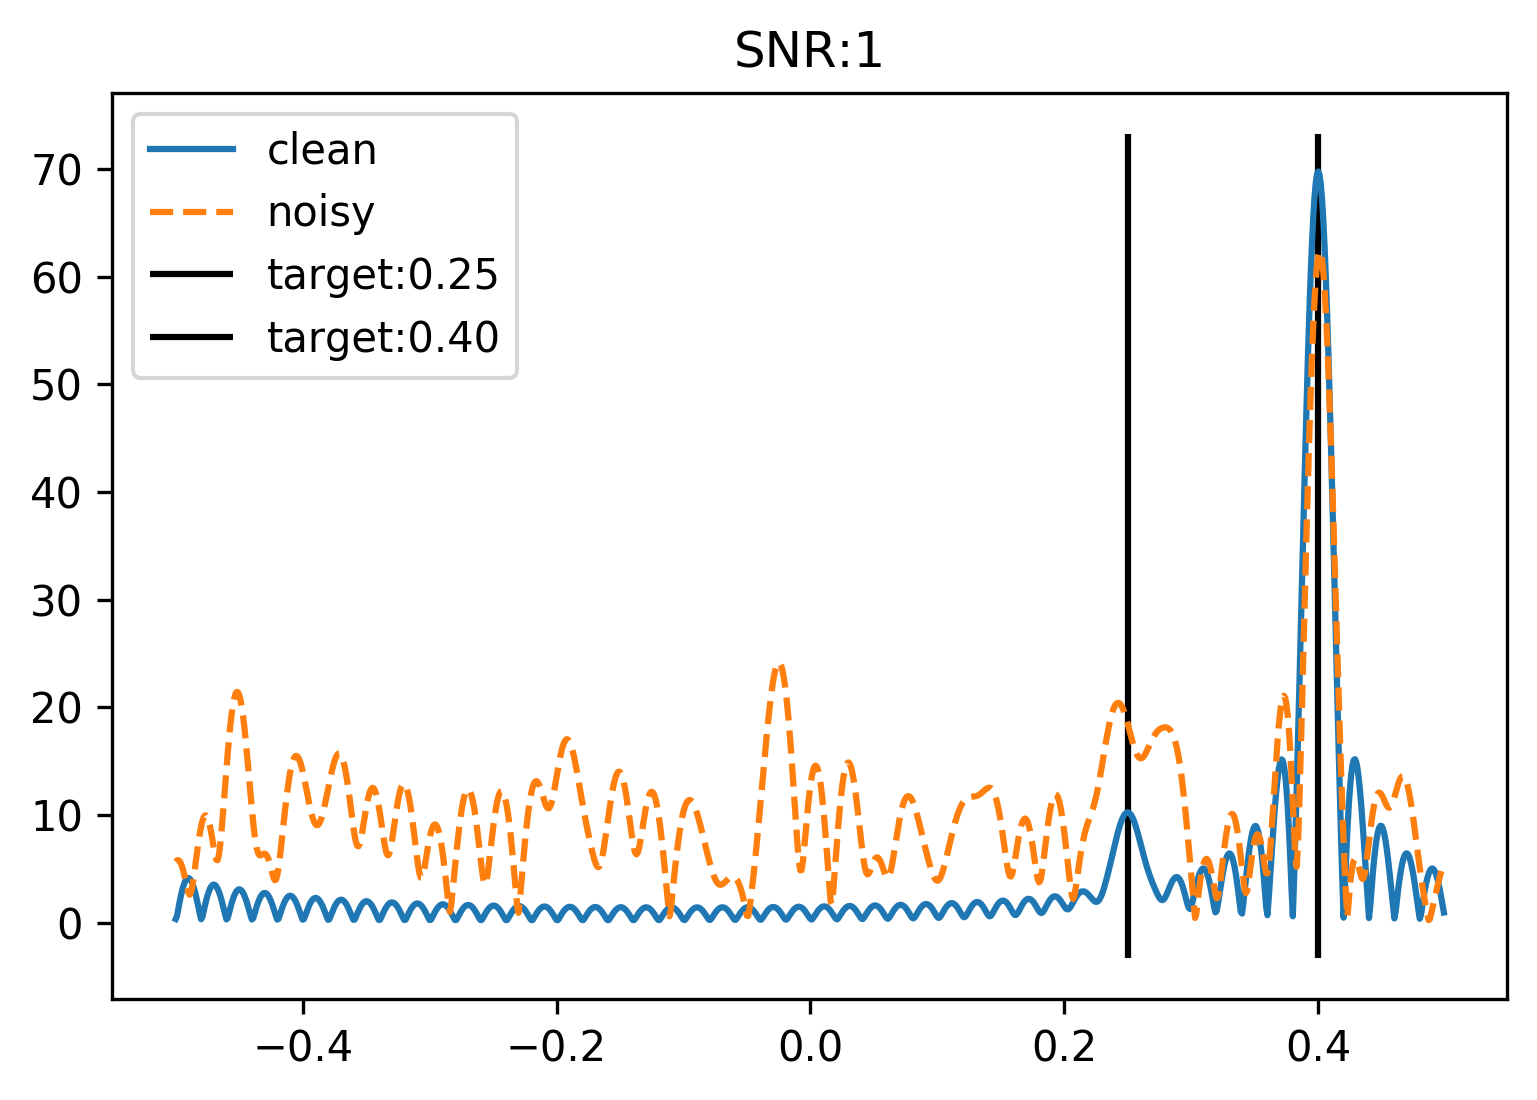

In [38]:
fig, ax = plt.subplots(dpi=300)
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
ax.plot(xgrid, np.abs(clean_signal_fft),label='clean')
ax.plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy')
ylim = ax.get_ylim()
for i in range(signal_fr.shape[0]):
    ax.vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax.set_title('SNR:{}'.format(snr))
ax.legend()

(-0.5, 0.5)

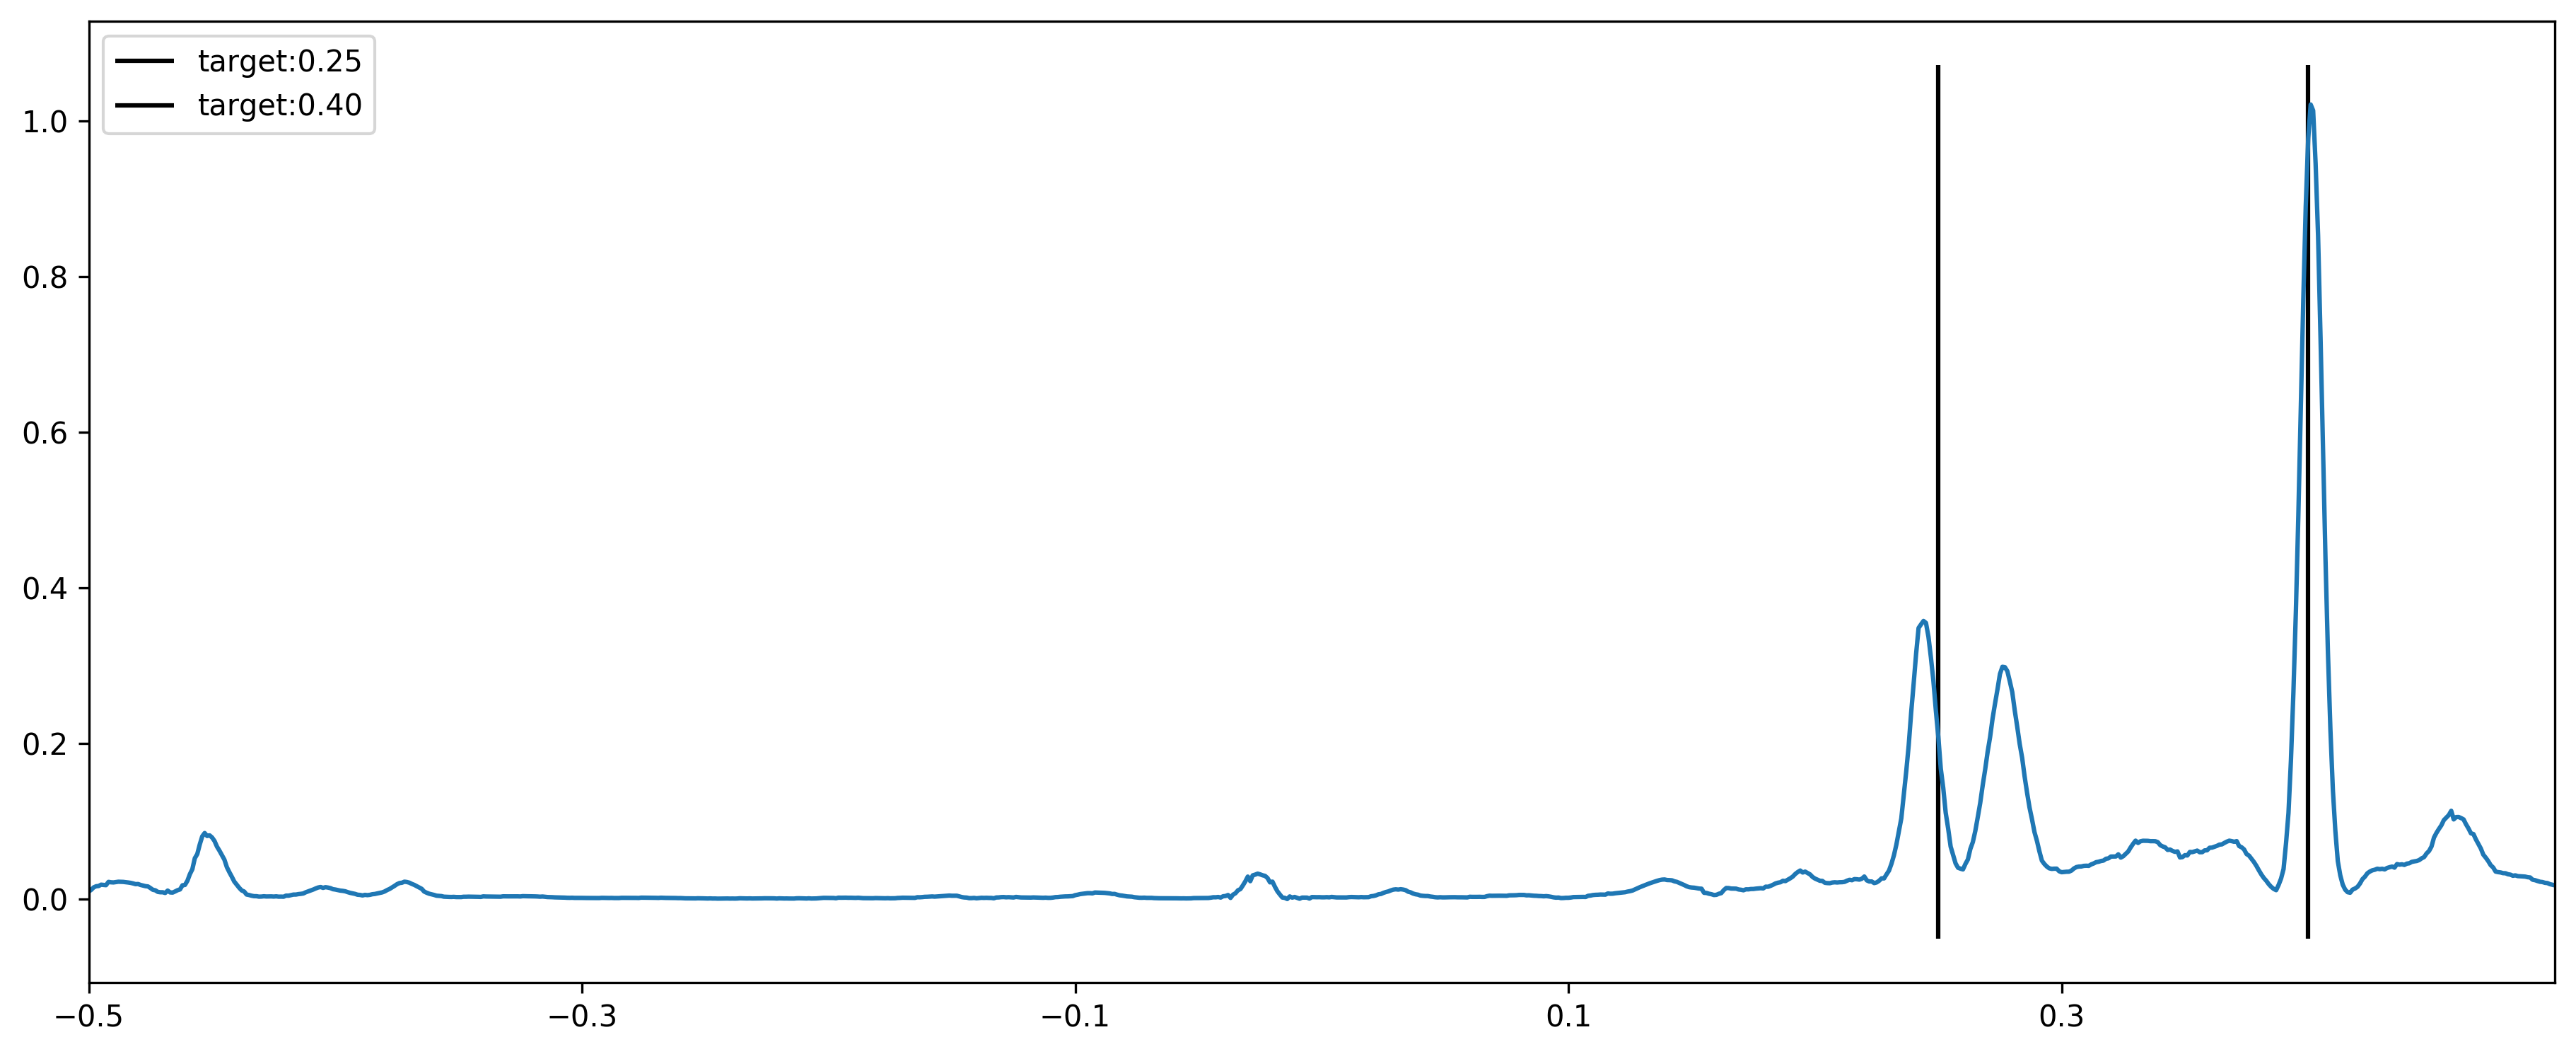

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), dpi=300)
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
ax.plot(xgrid, outputs[0])
ax.set_xticks(np.arange(-0.5, 0.5, 0.2))
ylim = ax.get_ylim()
for i in range(signal_fr.shape[0]):
    ax.vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax.legend()
ax.set_xlim(-0.5, 0.5)

In [40]:
fft_filter = jacobian[0] - 1j * jacobian[1]

## FFT  and Jacobian Row absolute value comparison

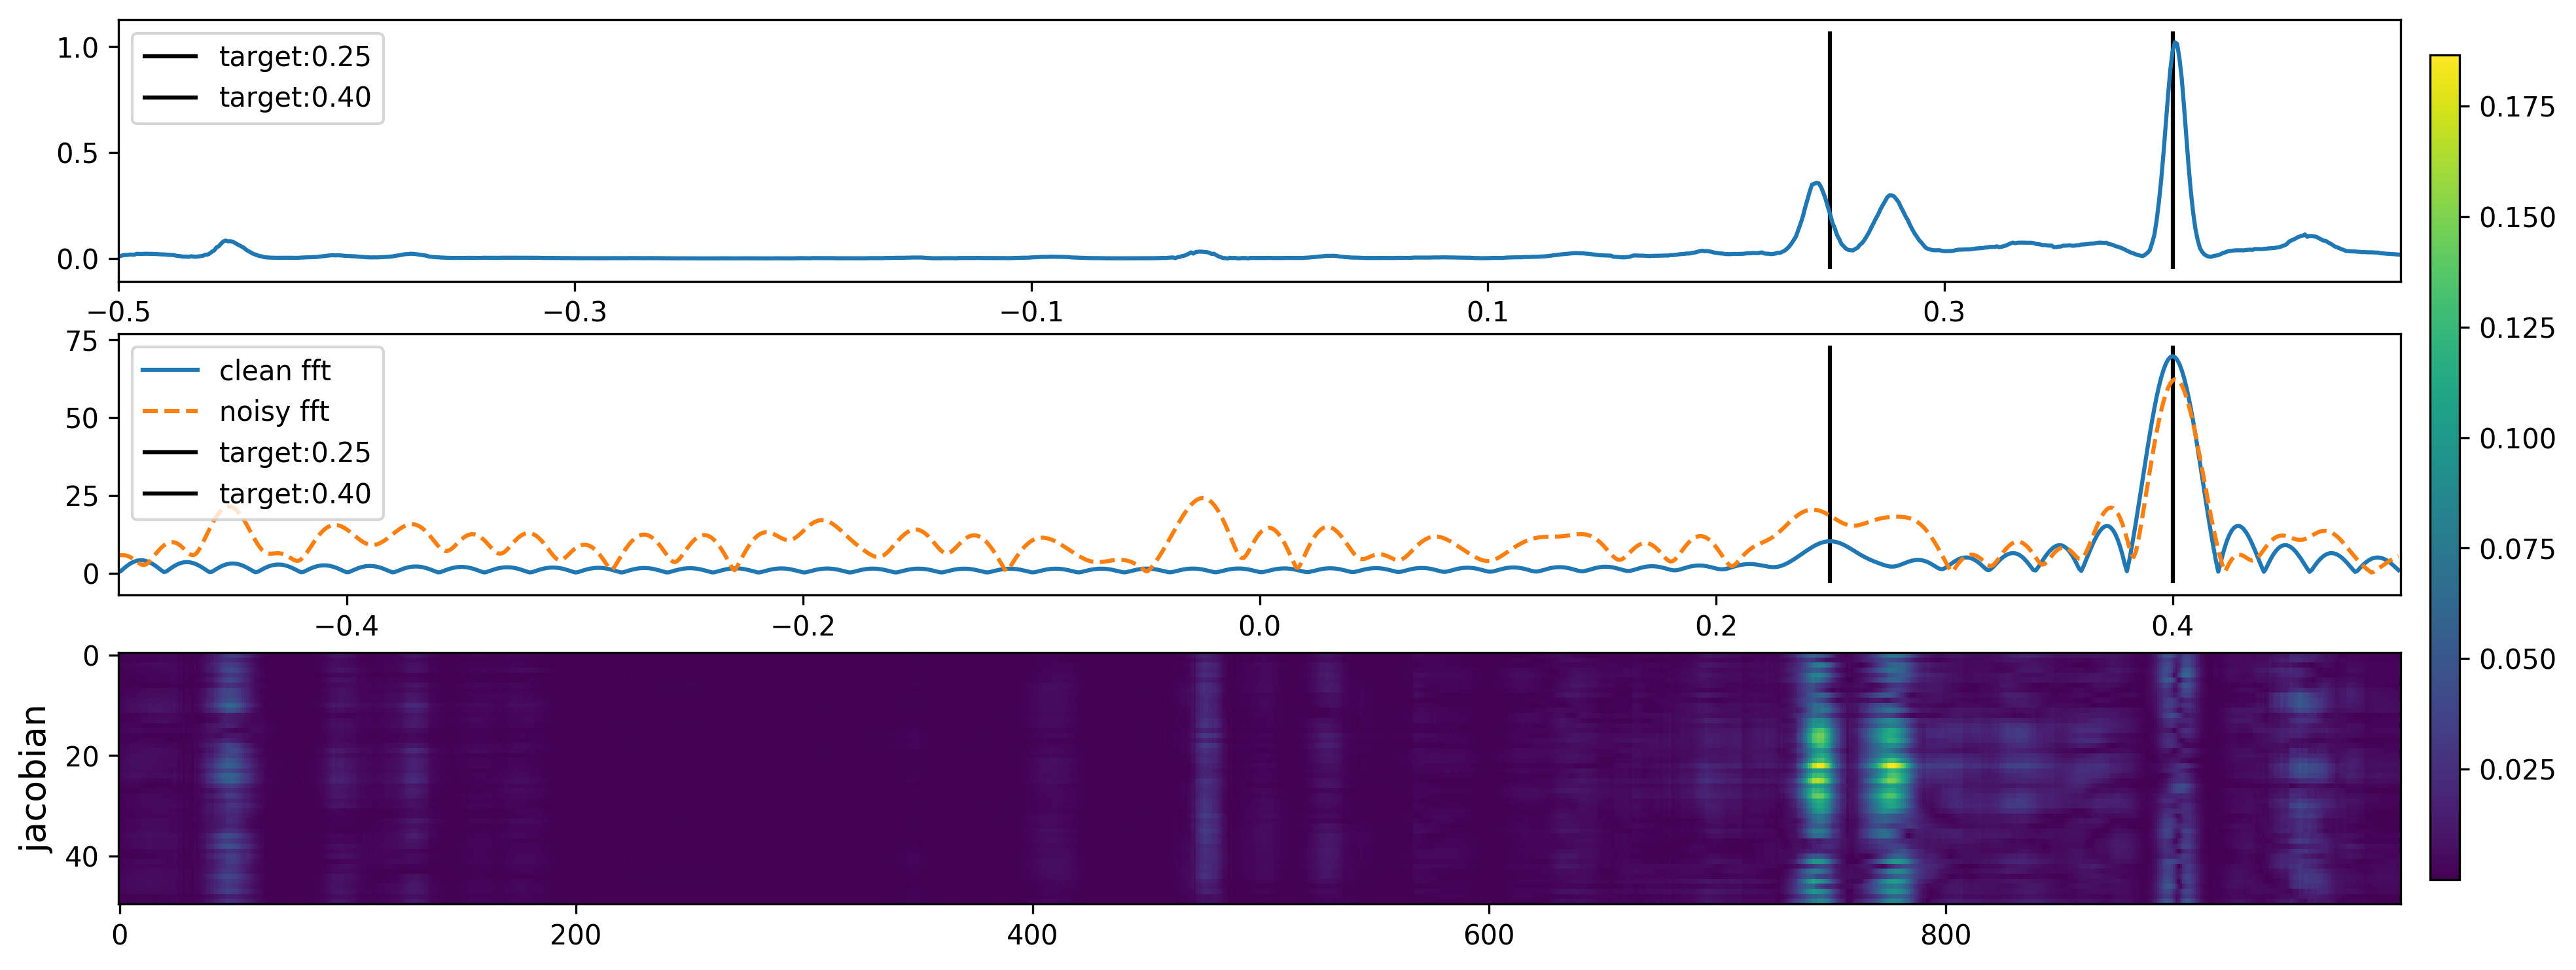

In [41]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6), dpi=300)
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ylim = ax[0].get_ylim()
for i in range(signal_fr.shape[0]):
    ax[0].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax[0].legend()
ax[0].set_xlim(-0.5, 0.5)
ax[1].plot(xgrid, np.abs(clean_signal_fft),label='clean fft')
ax[1].plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy fft')
ax[1].set_xlim(-0.5, 0.5)
ylim = ax[1].get_ylim()
for i in range(signal_fr.shape[0]):
    ax[1].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax[1].legend()
im = ax[2].imshow(np.abs(fft_filter))
ax[2].set_aspect(2.2)
ax[2].set_ylabel('jacobian', fontsize=13)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

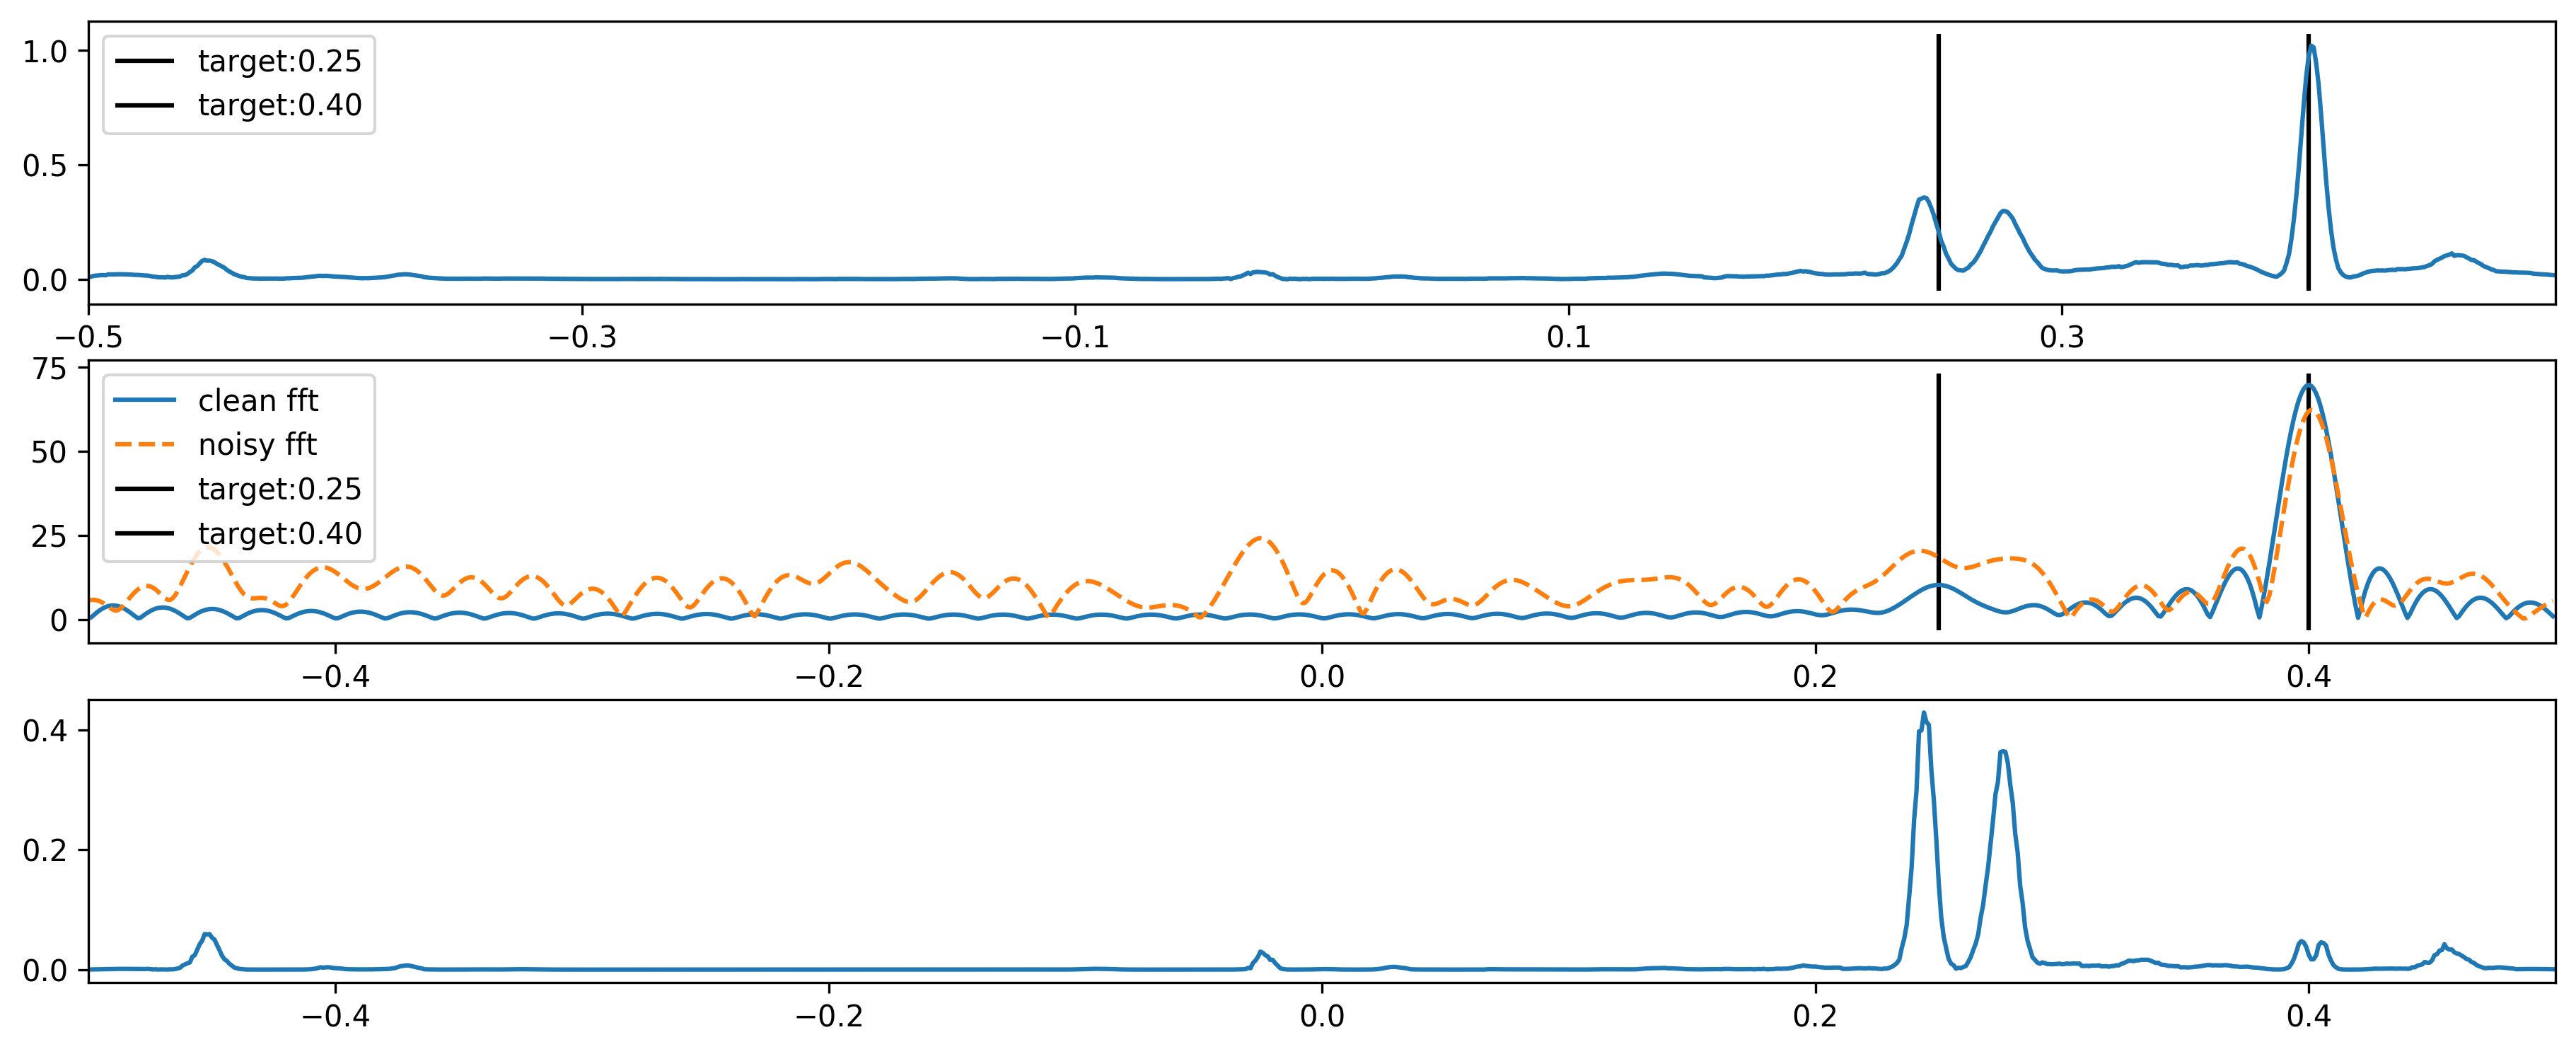

In [42]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6),dpi=300)
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)
ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ylim = ax[0].get_ylim()
for i in range(signal_fr.shape[0]):
    ax[0].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax[0].legend()

ax[1].plot(xgrid, np.abs(clean_signal_fft),label='clean fft')
ax[1].plot(xgrid, np.abs(noisy_signal_fft),'--', label='noisy fft')
ylim = ax[1].get_ylim()
for i in range(signal_fr.shape[0]):
    ax[1].vlines(signal_fr[i],ymin=ylim[0], ymax=ylim[1],label='target:{:4.2f}'.format(signal_fr[i]))
ax[1].legend()
fft_filter_norm = fft_filter * np.conjugate(fft_filter)
fft_filter_norm = fft_filter_norm.T.sum(axis=1).real
ax[2].plot(xgrid, fft_filter_norm)
ax[0].set_xlim(-0.5, 0.5)
ax[1].set_xlim(-0.5, 0.5)
ax[2].set_xlim(-0.5, 0.5)

fig.subplots_adjust(right=0.9)
plt.show()

## Plot the corresponding row to time and frequency domain

In [43]:
indices = find_neariest_idx(signal_fr, xgrid)
target_filter = fft_filter.T[indices]

In [44]:
target_filter.shape

(2, 50)

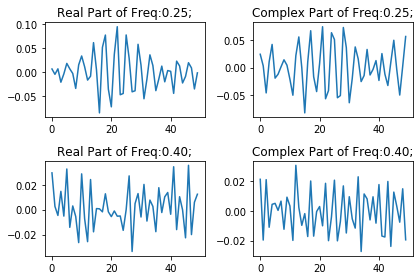

In [45]:
# time domain
fig, ax = plt.subplots(target_filter.shape[0], 2)
for idx, filt in enumerate(target_filter):
    if target_filter.shape[0] > 1:
        ax[idx, 0].plot(filt.real)
        ax[idx, 1].plot(filt.imag)
        ax[idx, 0].set_title('Real Part of Freq:{:4.2f};'.format(signal_fr[idx]))
        ax[idx, 1].set_title('Complex Part of Freq:{:4.2f};'.format(signal_fr[idx]))
    else:
        ax[0].plot(filt.real)
        ax[1].plot(filt.imag)
        ax[0].set_title('Real Part of Freq:{:4.2f};'.format(signal_fr[idx]))
        ax[1].set_title('Complex Part of Freq:{:4.2f};'.format(signal_fr[idx]))
plt.tight_layout()

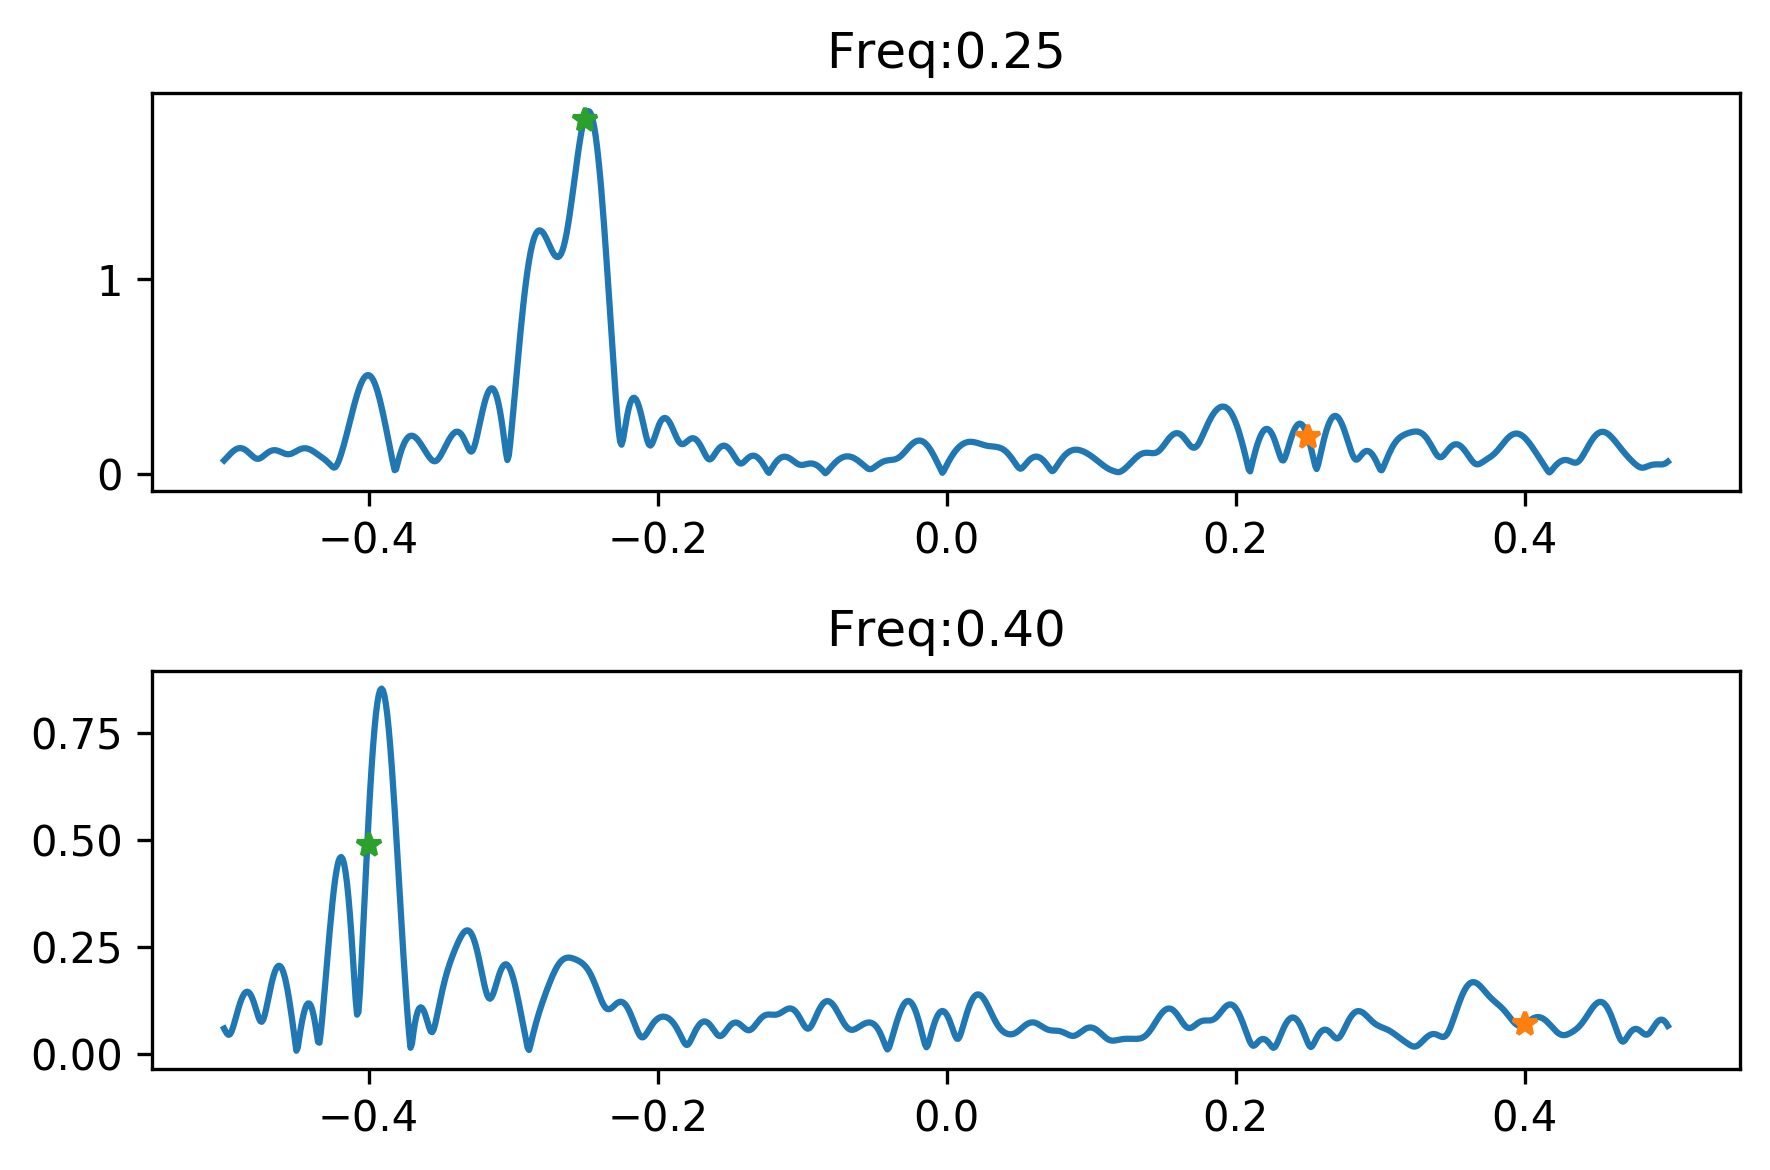

In [46]:
# fft domian of signals
fig, ax = plt.subplots(target_filter.shape[0], 1,  dpi=300)
for idx, filt in enumerate(target_filter):
    filt_fft = np.fft.fft(filt,n=1000)
    filt_fft = np.fft.fftshift(filt_fft)
    magnitude = np.abs(filt_fft)
    if target_filter.shape[0] > 1:
        ax[idx].plot(xgrid, magnitude)
        ax[idx].plot(signal_fr[idx], magnitude[indices[idx]], '*')
        ax[idx].plot(-signal_fr[idx], magnitude[999 - indices[idx]], '*')
        ax[idx].set_title('Freq:{:4.2f}'.format(signal_fr[idx]))
    else:
        ax.plot(xgrid, magnitude)
        ax.plot(signal_fr[idx], magnitude[indices[idx]], '*')
        ax.plot(-signal_fr[idx], magnitude[999-indices[idx]], '*')
        ax.set_title('Freq:{:4.2f}'.format(signal_fr[idx]))
plt.tight_layout()

In [50]:
fft_filter.shape

(50, 1000)

In [48]:
target_filter.shape

(2, 50)

In [100]:
from scipy.signal import find_peaks
def jac_row_plot(idx, freq_label, filt_non,n=5):
    fig, ax = plt.subplots(dpi=300)

    filt_fft = np.fft.fft(filt_non,n=1000)
    filt_fft = np.fft.fftshift(filt_fft)
    magnitude = np.abs(filt_fft)
    peaks_indices = find_peaks(magnitude)[0]
    peaks_magnitude = magnitude[peaks_indices]
    sorted_indices = np.argsort(peaks_magnitude)[::-1]
    peak_indices = peaks_indices[sorted_indices][:5]
    ax.plot(xgrid, magnitude)
    ax.plot(freq_label, magnitude[idx],  '*', label='freq={:4.4f}'.format(freq_label))
    for sort_idx in peak_indices:
        ax.annotate('{:4.4f}'.format(xgrid[sort_idx]),
                   xy=(xgrid[sort_idx], magnitude[sort_idx]),
                   arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='left',
                verticalalignment='bottom')
        ax.plot(xgrid[sort_idx], magnitude[sort_idx], '*', color='black')
    ax.set_title('Freq:{:4.4f}'.format(freq_label))
    plt.tight_layout()
    plt.legend()
    return fig, ax

In [107]:
# plot some other rows
# fft domian of signals
start=700
end=800
interval=1
file_name = 'jac_row_s_{}_e_{}_i_{}.pdf'.format(start, end, interval)
pdf = matplotlib.backends.backend_pdf.PdfPages("./plots/" + file_name)

for idx in range(start, end, interval):
    freq_label = xgrid[idx]
    filt_non = fft_filter.T[idx]
    fig, ax = jac_row_plot(idx, freq_label, filt_non, n=5)
    pdf.savefig(fig)
    plt.close()
pdf.close()
    

In [72]:
peaks_indices

array([34, 57])

## SVD on Jacobian matrices

In [110]:
fft_filter_svd = fft_filter.T
u,s, vh = np.linalg.svd(fft_filter_svd)

In [111]:
# hyper parameter setting
num_samples=20
signal_dim=50
min_sep=1.
snr_list=[1, 5, 10, 30, 50]
#fixed_freq = [0.1,0.15, 0.2, 0.25, 0.3, 0.35, 0.4] # set None for  random frequency
fixed_freq = [0.4]
num_freq=len(fixed_freq)

In [112]:
# compute Jacobian for noisy signal
def compute_jacobian_realization(num_samples, signal_dim, num_freq, min_sep, fixed_freq, snr):
    clean_signals, signal_frs, signal_num_freqs = gen_signal(num_samples=num_samples, 
                                                         signal_dim=signal_dim, 
                                                         num_freq=num_freq, min_sep=min_sep,
                                                        fixed_freq=fixed_freq)
    noisy_signals = noise_torch(torch.as_tensor(clean_signals), snr, 'gaussian')
    jacobian_realization =  []
    jacobian_realization_clean =  []
    for idx in range(clean_signals.shape[0]):
        clean_signal, signal_fr, signal_num_freq = clean_signals[idx], signal_frs[idx], signal_num_freqs[idx]
        noisy_signal = noisy_signals[idx].cpu().numpy()
        clean_signal_t = clean_signal[0] + clean_signal[1] * 1j 
        clean_signal_fft = np.fft.fft(clean_signal_t, n=1000)
        clean_signal_fft = np.fft.fftshift(clean_signal_fft)
        noisy_signal_t = noisy_signal[0] + 1j * noisy_signal[1]
        noisy_signal_fft = np.fft.fft(noisy_signal_t, n=1000)
        noisy_signal_fft = np.fft.fftshift(noisy_signal_fft)
        noisy_signal = torch.as_tensor(noisy_signal).unsqueeze(dim=0)
        jacobian, inputs, outputs = compute_jacobian_and_bias(noisy_signal, fr_module)
        clean_signal = torch.as_tensor(clean_signal).unsqueeze(dim=0)
        jacobian_clean, inputs, outputs = compute_jacobian_and_bias(clean_signal, fr_module)
        jacobian_realization.append(jacobian)
        jacobian_realization_clean.append(jacobian_clean)
    return jacobian_realization, jacobian_realization_clean

def get_svd(jacobian_realization):
    eigenvals = []
    left_eigenvecs = []
    right_eigenvecs = []
    eff_dims = []
    for jac in jacobian_realization:
        u, s, vh = svd_jacobian(jac)
        eigenvals.append(s)
        left_eigenvecs.append(u)
        right_eigenvecs.append(vh)
        effective_dim = np.sum(s ** 2)
        eff_dims.append(effective_dim)
        print(effective_dim)
    return eigenvals, left_eigenvecs, right_eigenvecs, eff_dims
def plot_eigenvec(n, u, reverse=False):
    fig, ax =  plt.subplots(n, 1, dpi=300)
    for i in range(n):
        if reverse:
            pc1 = u[:, 49-i]
        else:
            pc1 = u[:, i]
        ax[i].plot(xgrid, np.abs(pc1),label='abs', lw=1)
        #ax[i].plot(xgrid, pc1.real, '--*',label='real',markersize=2)
        #ax[i].plot(xgrid, pc1.imag, '--x', label='imag',markersize=1)
    plt.tight_layout()
    return fig
def plot_eigenval(eigenvals):
    fig = plt.figure(dpi=300)
    for each in eigenvals:
        plt.plot(each, color='blue')
    plt.grid()
    return fig

In [303]:
results = {}
for snr in snr_list:
    results[snr]={}
    jacobian_realization, jacobian_realization_clean = compute_jacobian_realization(num_samples, 
                                                                                    signal_dim, 
                                                                                    num_freq, 
                                                                                    min_sep, 
                                                                                    fixed_freq, 
                                                                                    snr)
    eigenvals, left_eigenvecs, right_eigenvecs, eff_dims = get_svd(jacobian_realization)
    eigenvals_cl, left_eigenvecs_cl, right_eigenvecs_cl, eff_dims_cl = get_svd(jacobian_realization_clean)
    results[snr]['noisy'] = (eigenvals, left_eigenvecs, right_eigenvecs, eff_dims)
    results[snr]['clean'] = (eigenvals_cl, left_eigenvecs_cl, right_eigenvecs_cl, eff_dims_cl)
    

1278.9474
973.43445
1204.0817
895.4124
1647.2706
1138.0153
1030.81
969.64056
1246.9799
998.19543
1515.5759
779.1437
660.75836
980.83093
1250.3287
1292.5511
863.2411
1207.1876
1101.5869
1206.5746
6.9574885
0.57530606
0.49009392
0.67373776
7.8133097
0.72769266
0.88985753
0.70435876
0.5819387
0.5473314
0.58454156
0.6060879
3.5696113
0.6577504
0.6850286
4.642998
0.61798245
127.46666
19.774055
0.85004765
1097.3889
1192.1864
895.2609
1286.9137
465.02487
1649.5364
992.42535
1172.5559
1053.0126
1561.051
930.95526
911.27686
960.8419
1058.6533
1046.9244
1022.8614
869.3097
882.91895
1057.3237
643.57135
0.64247775
0.6130779
0.6812823
2.6644285
0.58349216
0.5919536
0.74700683
0.57078475
0.6170449
0.5747779
0.5759997
0.58261275
0.6457921
0.5549311
0.57417214
0.5320533
0.7082281
0.56631845
0.62905604
0.6960612
257.17374
467.40823
452.3617
416.59952
547.07513
240.04695
1071.3593
493.8878
27.625528
300.8564
466.95184
472.52548
561.11804
294.5023
514.0911
550.612
329.92352
908.5307
699.8013
442.2824
62.

In [307]:
# cached 
import pickle
with open('saved_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [10]:
# load
import pickle
with open('saved_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [22]:
n=5
for snr in snr_list:
    pdf1 = matplotlib.backends.backend_pdf.PdfPages("./plots/noise_{}.pdf".format(snr))
    pdf2 = matplotlib.backends.backend_pdf.PdfPages("./plots/clean_{}.pdf".format(snr))
    eigenvals, left_eigenvecs, right_eigenvecs, eff_dims = results[snr]['noisy']
    fig1 = plot_eigenval(eigenvals)
    fig2 = plot_eigenvec(n, left_eigenvecs[0])
    fig3 = plot_eigenvec(n, left_eigenvecs[0], reverse=True)
    
    pdf1.savefig(fig1)
    pdf1.savefig(fig2)
    pdf1.savefig(fig3)
    pdf1.close()
    plt.close(fig1)
    plt.close(fig2)
    plt.close(fig3)
    eigenvals_cl, left_eigenvecs_cl, right_eigenvecs_cl, eff_dims_cl = results[snr]['clean']
    fig1 = plot_eigenval(eigenvals_cl)
    fig2 = plot_eigenvec(n, left_eigenvecs_cl[0])
    fig3 = plot_eigenvec(n, left_eigenvecs_cl[0], reverse=True)
    pdf2.savefig(fig1)
    pdf2.savefig(fig2)
    pdf2.savefig(fig3)
    pdf2.close()
    plt.close(fig1)
    plt.close(fig2)
    plt.close(fig3)

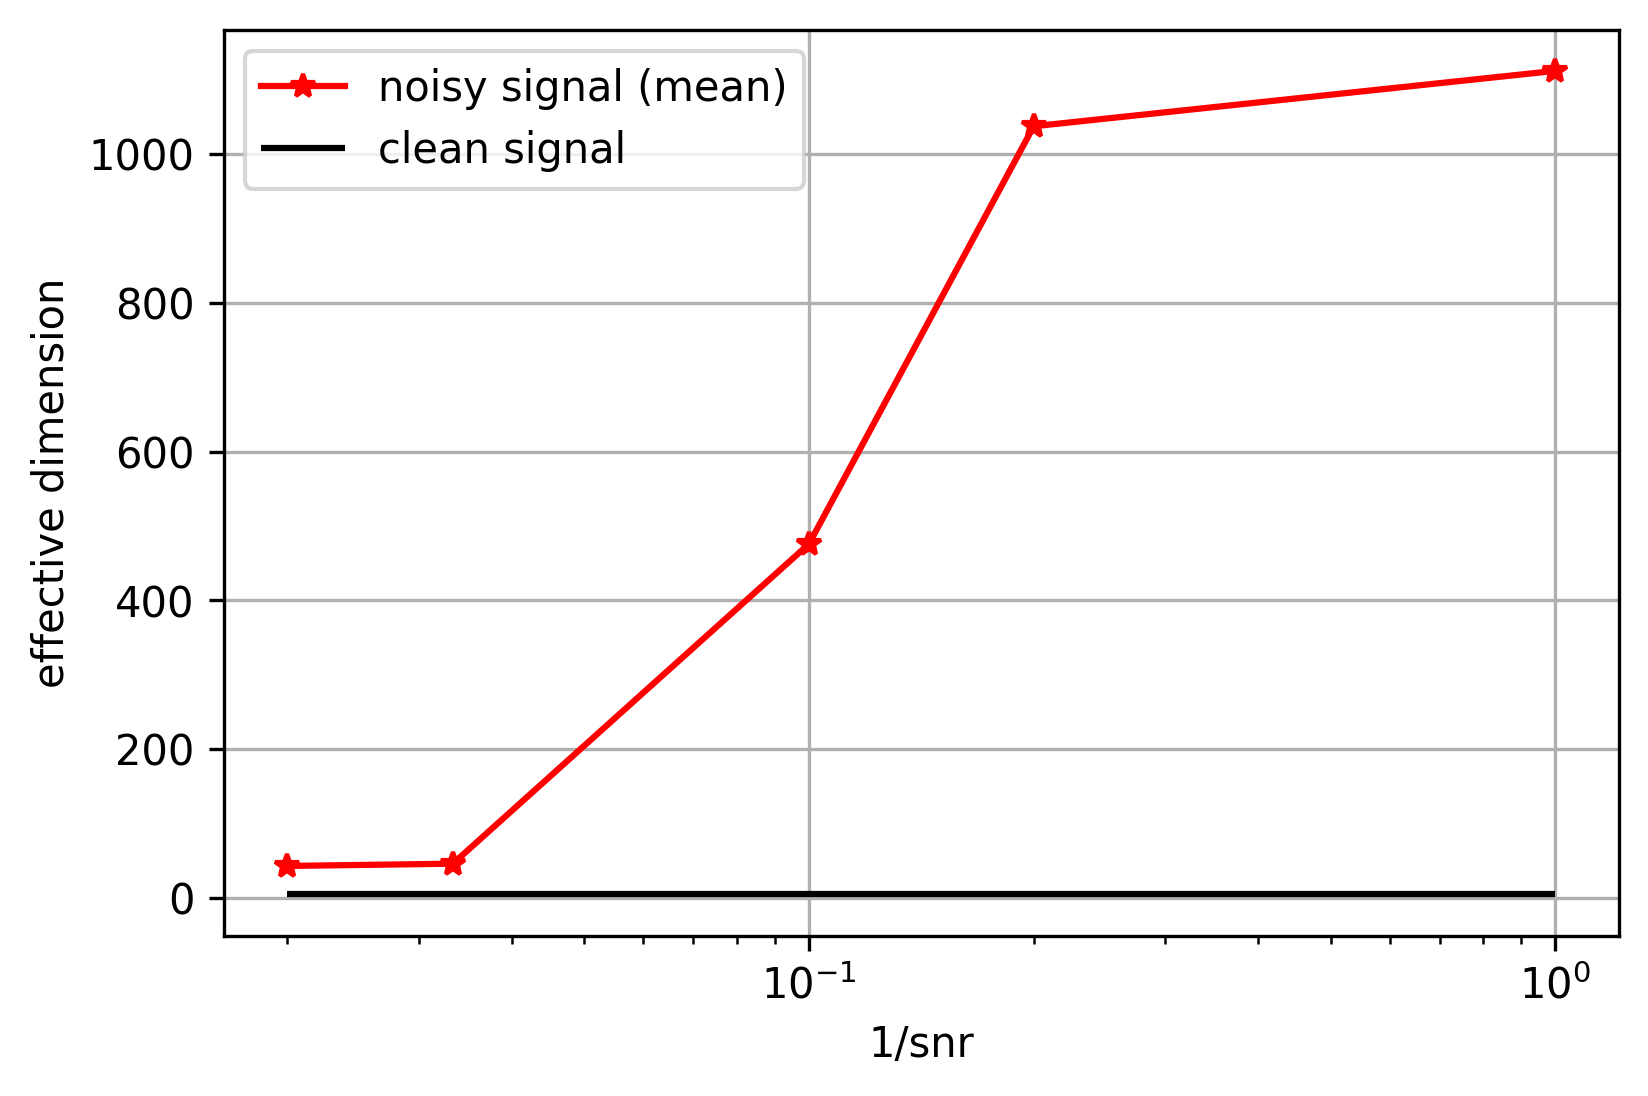

In [337]:
#  effective dimensions
n=5
mean_eff_dims = []
mean_eff_dims_cl = []
plt.figure(dpi=300)
data_to_plot = []
for snr in snr_list:
    eigenvals, left_eigenvecs, right_eigenvecs, eff_dims = results[snr]['noisy']
    eigenvals_cl, left_eigenvecs_cl, right_eigenvecs_cl, eff_dims_cl = results[snr]['clean']
    mean_eff_dims.append(np.mean(eff_dims))
    mean_eff_dims_cl.append(np.mean(eff_dims_cl))
    data_to_plot.append(eff_dims)
data_to_plot = np.stack(data_to_plot).T
#for i in range(data_to_plot.shape[0]):
#    plt.plot(snr_list, data_to_plot[i], color='blue', lw=1)
x = 1/np.array(snr_list)
plt.semilogx(x, mean_eff_dims,'-*', color='red', label='noisy signal (mean)')
plt.hlines(np.mean(mean_eff_dims_cl),xmin=x.min(), xmax=x.max(),label='clean signal')
plt.grid()
plt.xlabel('1/snr')
plt.ylabel('effective dimension')
plt.legend()

In [328]:
data_to_plot.shape

(5, 20)

In [317]:
x=1/np.array(snr_list)

In [318]:
x.tolist()

[1.0, 0.2, 0.1, 0.03333333333333333, 0.02]

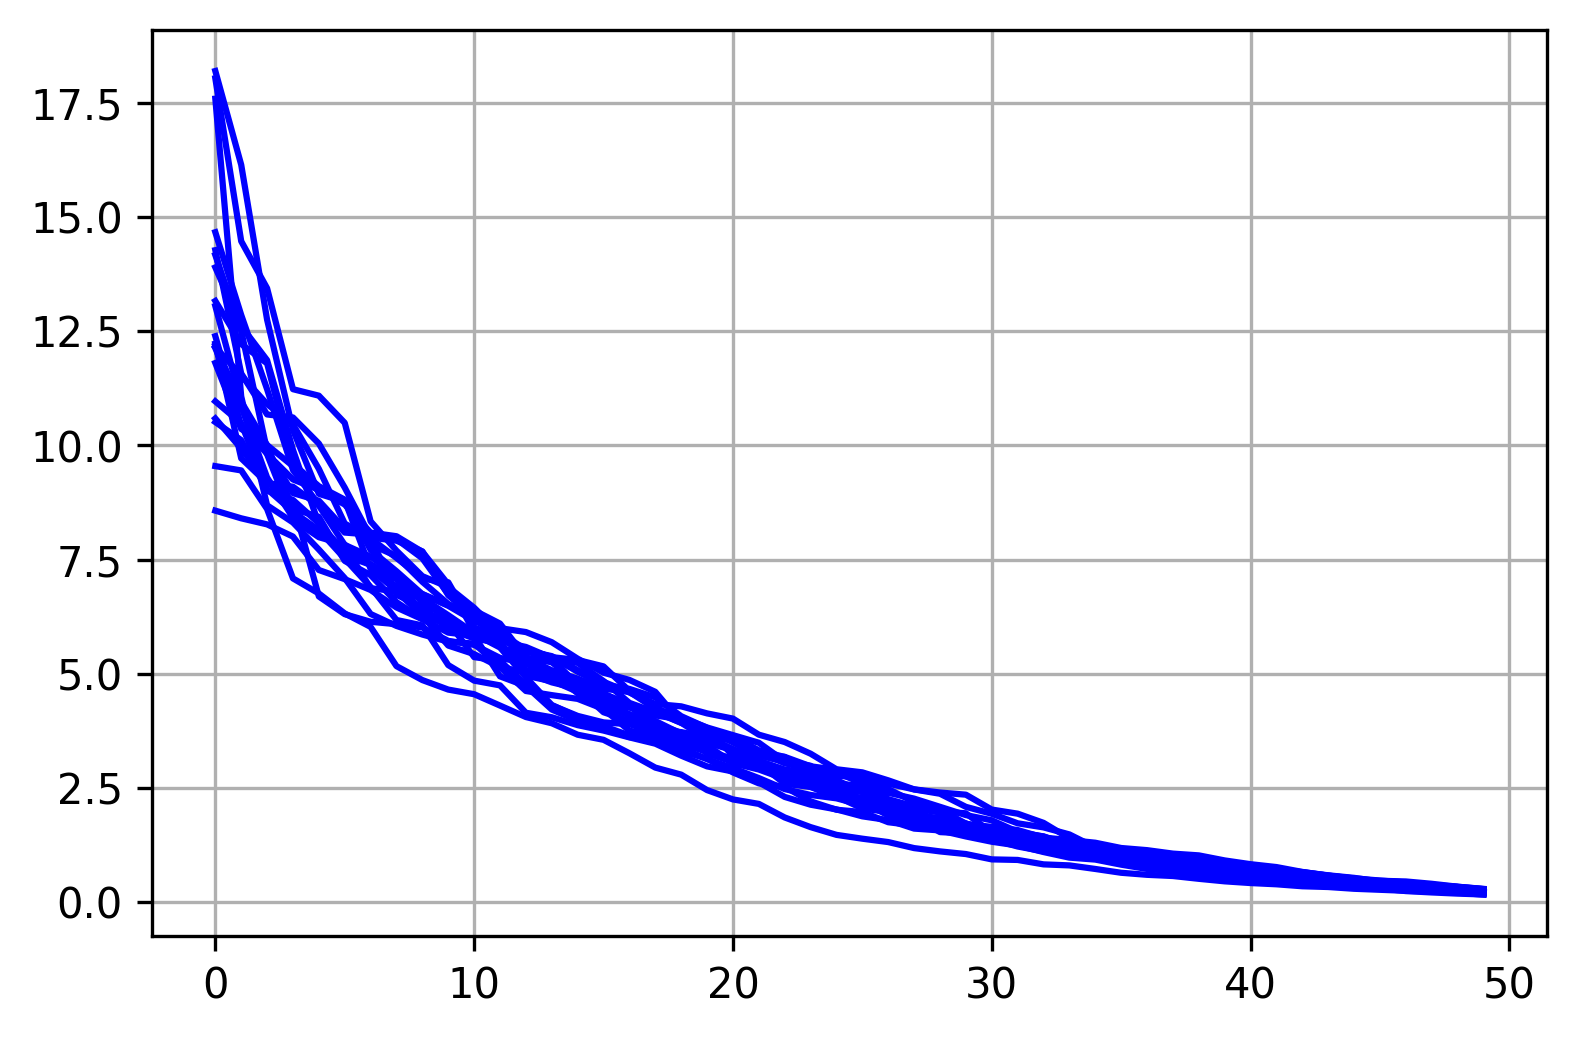

In [15]:

fig = plot_eigenval(eigenvals)

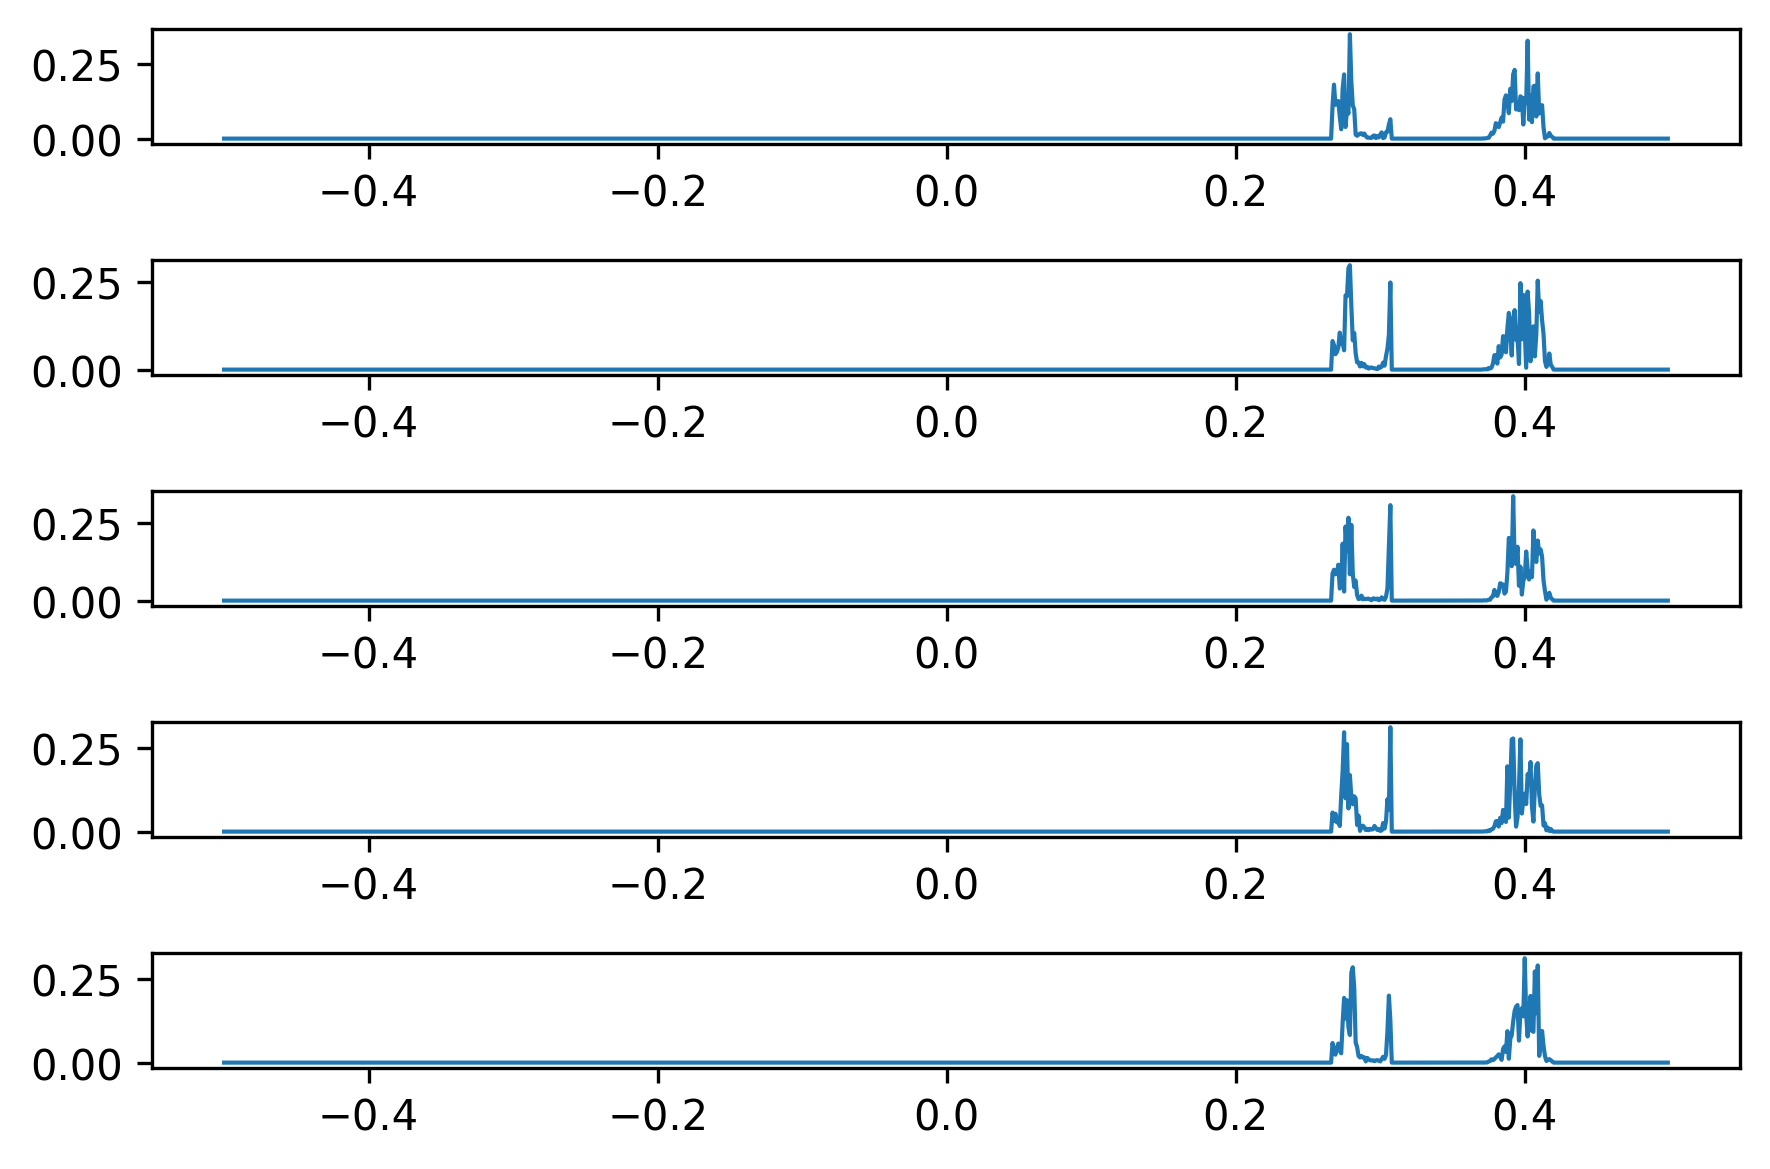

In [293]:
plot_eigenvec(n, u, reverse=True)

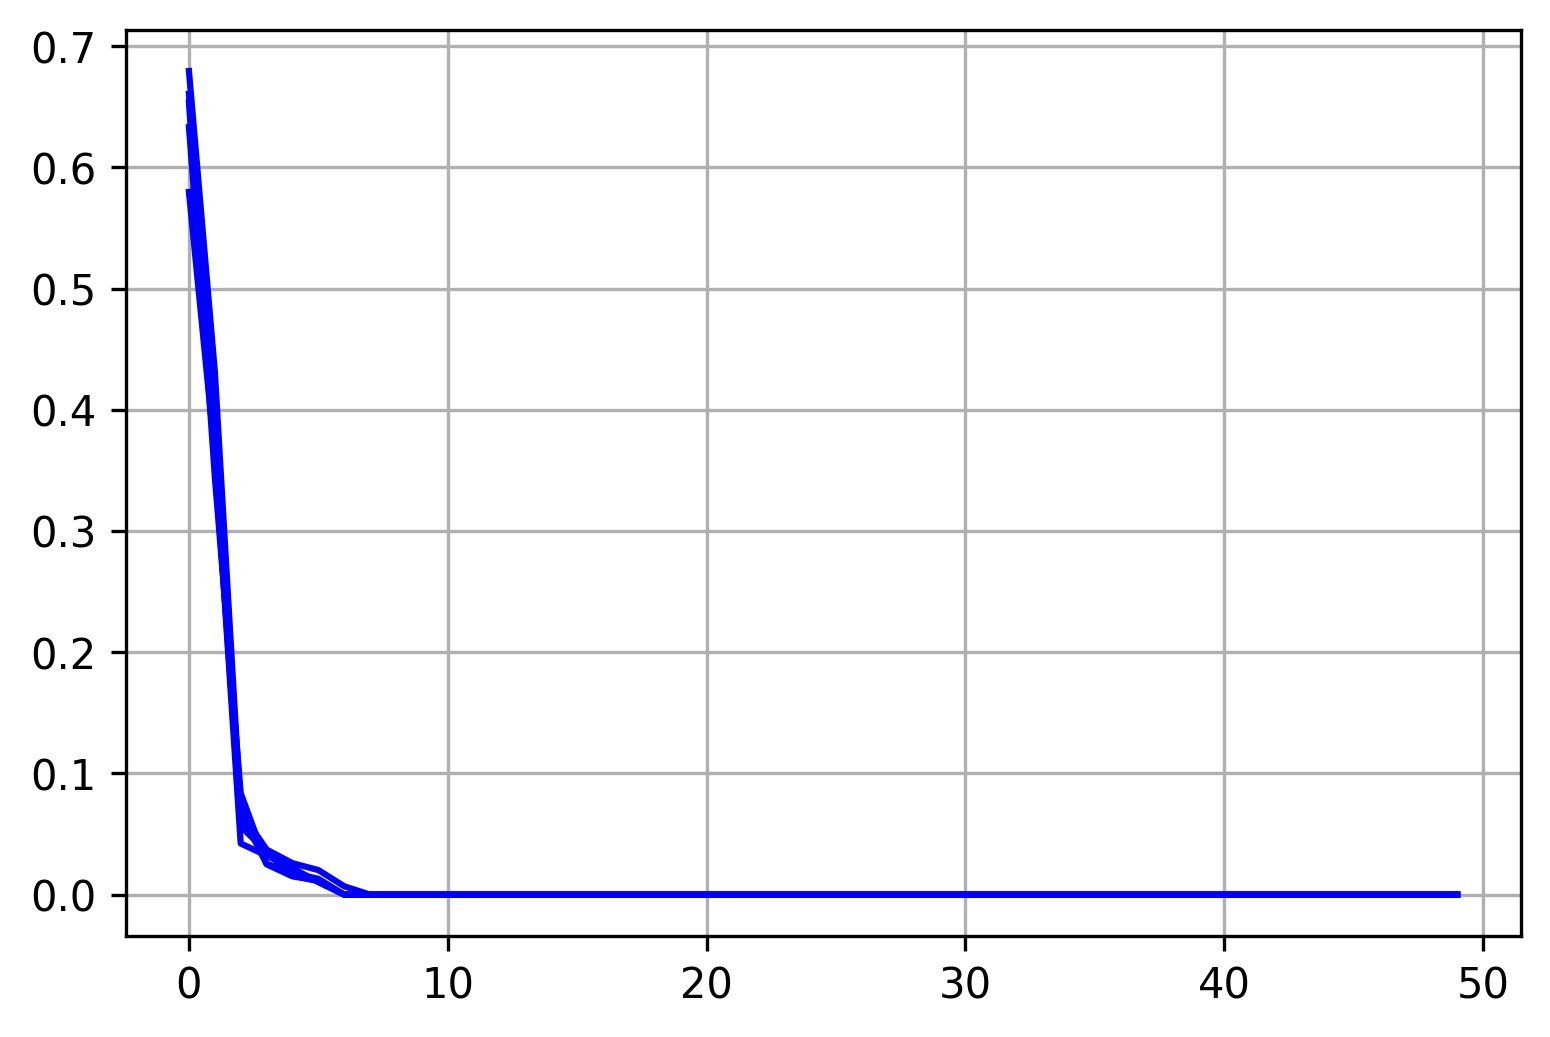

In [294]:
plot_eigenval(eigenvals_cl)

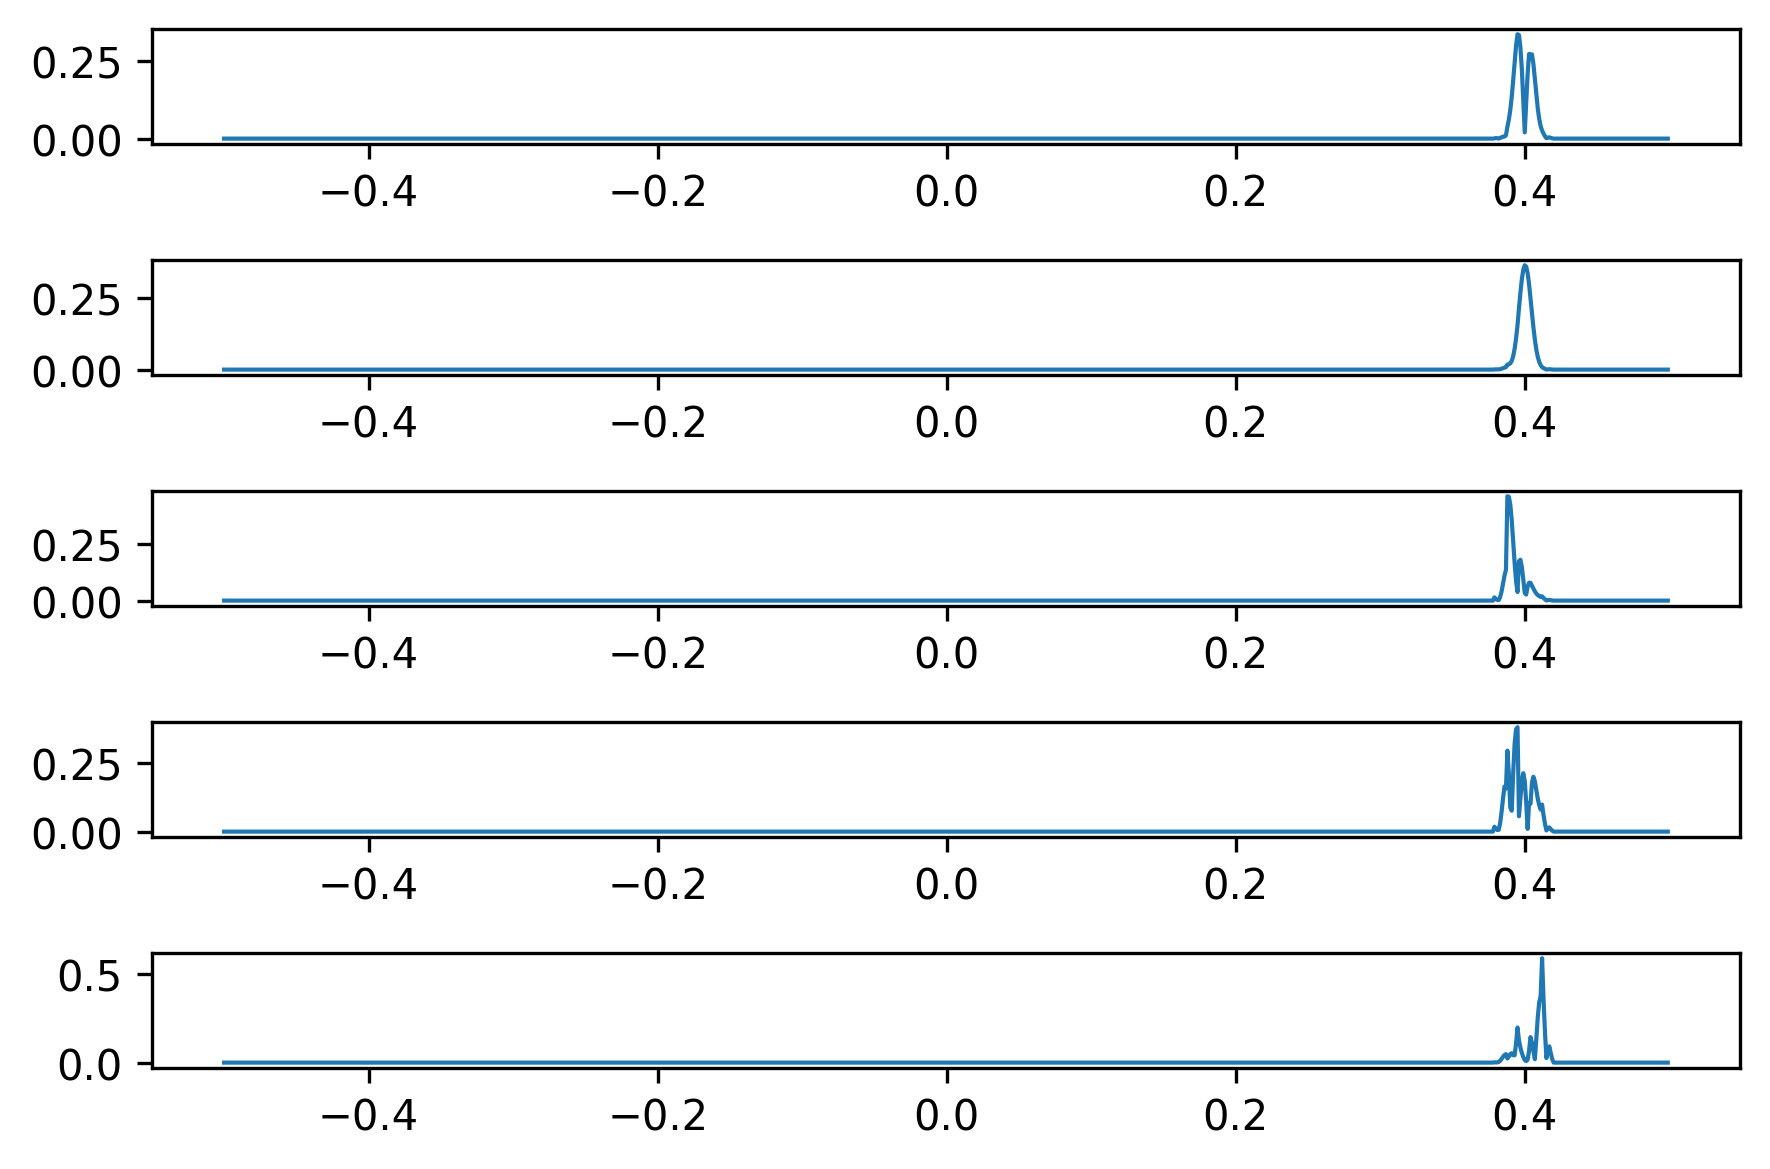

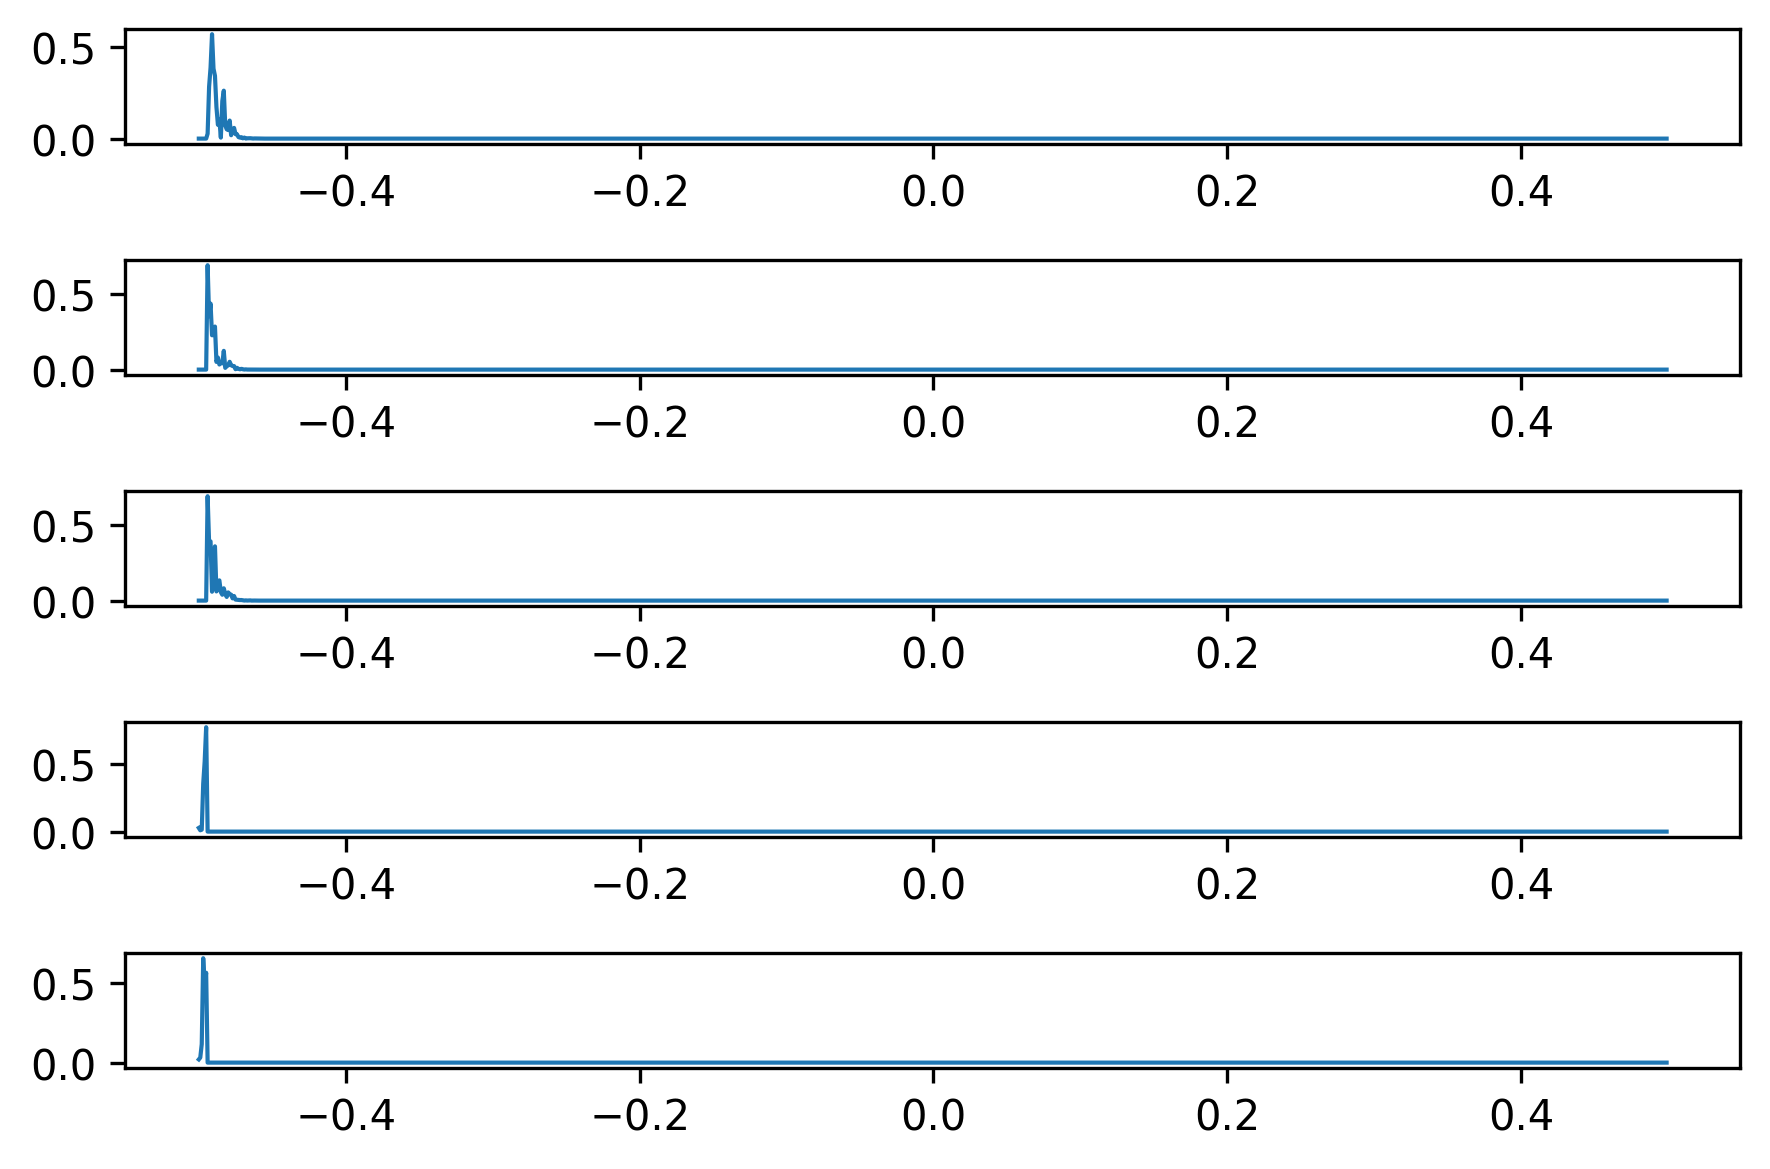

In [295]:
u = left_eigenvecs_cl[0]
plot_eigenvec(5, u)
plot_eigenvec(5,u,reverse=True)

## PCA

In [164]:
# hyper parameter setting
num_samples=20
signal_dim=50
min_sep=1.
snr_list=[1, 5, 10, 30, 50]
#fixed_freq = [0.1,0.15, 0.2, 0.25, 0.3, 0.35, 0.4] # set None for  random frequency
fixed_freq = [0.4]
num_freq=len(fixed_freq)
jac, jac_clean = compute_jacobian_realization(num_samples, 
                                              signal_dim, 
                                              num_freq, 
                                              min_sep, 
                                              fixed_freq, 
                                              snr)
jac = np.stack(jac)

In [165]:
# print PCA results
def pca_plots(xgrid, target_freq, num_samples, signal_dim, idx_comp=0, fixed_freq_idx=0, arbitary_row=None):
    if arbitary_row is None:
        target_freq = fixed_freq[fixed_freq_idx]
        #  get target prediction
        row_idx = np.abs(xgrid  - target_freq).argsort()[0]
    else:
        row_idx = arbitary_row
        target_freq = xgrid[arbitary_row]
    dataset = 1j * np.zeros((num_samples, signal_dim))
    for i in range(num_samples):
        jacobian = jac[i]
        dataset[i] = jacobian[0, :, row_idx] - 1j * jacobian[1, : ,row_idx]
    signal_cov = np.cov(dataset.T)
    s, u = np.linalg.eig(signal_cov)
    pc1 = u[:, idx_comp]
    pc1_fft = np.fft.fft(pc1, n=1000)
    pc1_fft = np.fft.fftshift(pc1_fft)
    pc1_fft = np.abs(pc1_fft)
    fig, ax = plt.subplots(dpi=300)
    ax.plot(xgrid, pc1_fft)
    ax.set_title('Freq {:2.4f}; PC:{}'.format(target_freq, idx_comp))

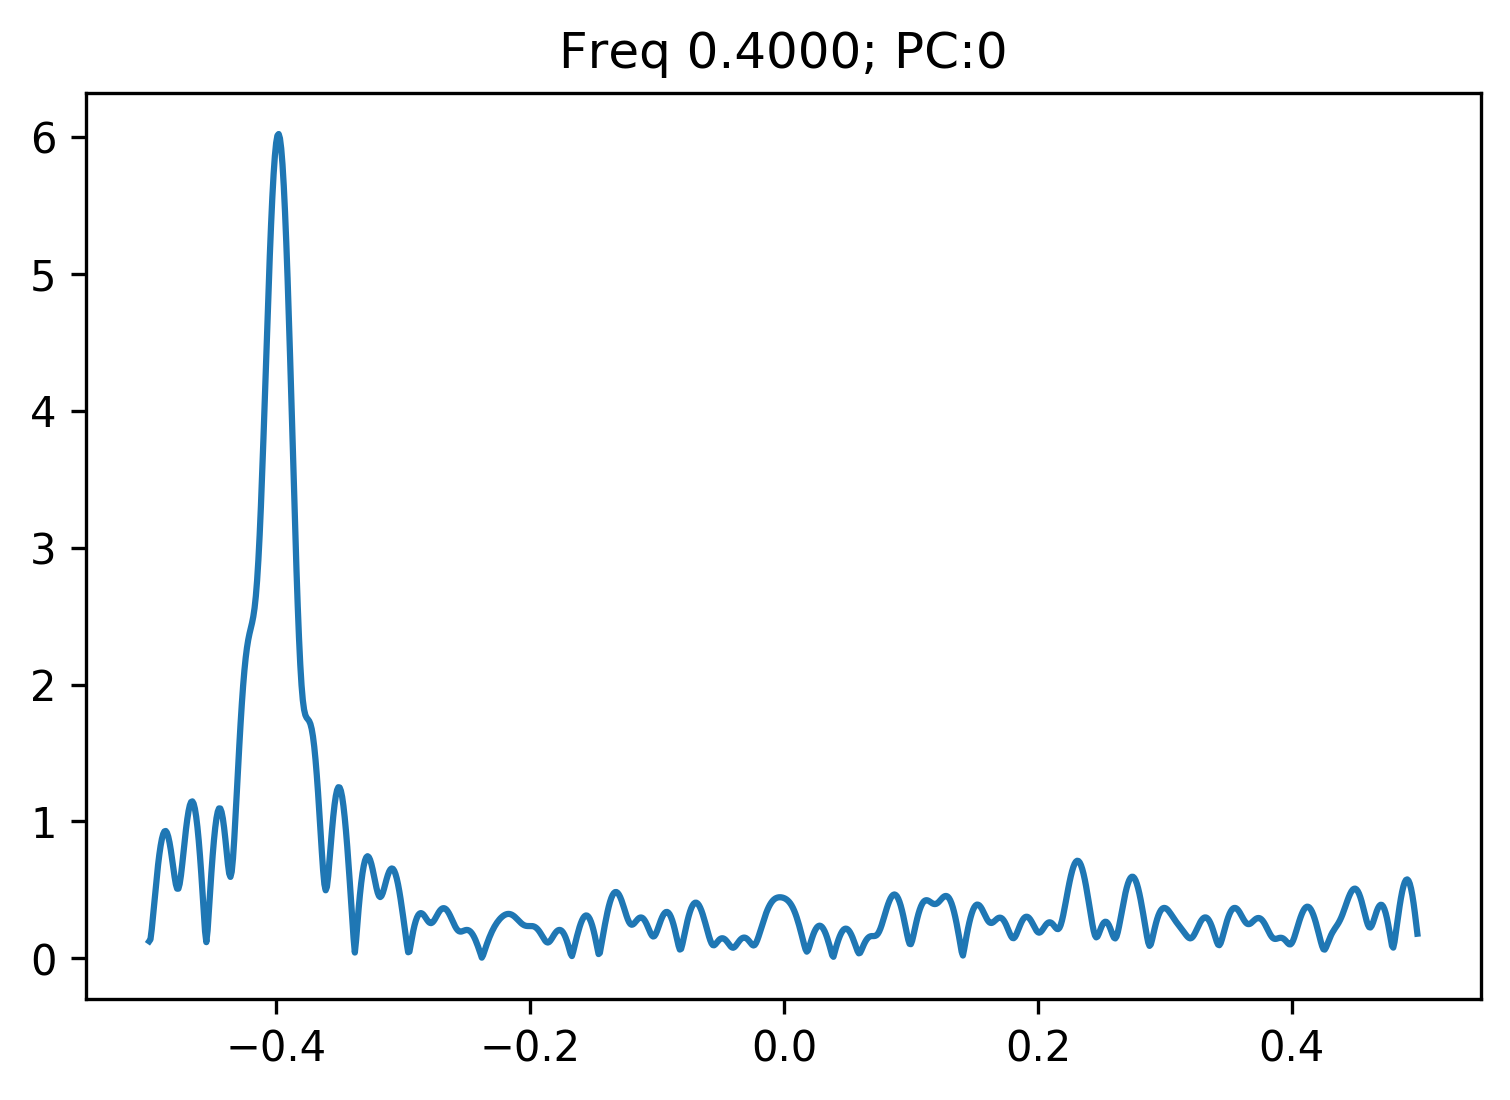

In [166]:
pca_plots(xgrid, target_freq, num_samples, signal_dim, idx_comp=0, fixed_freq_idx=0)

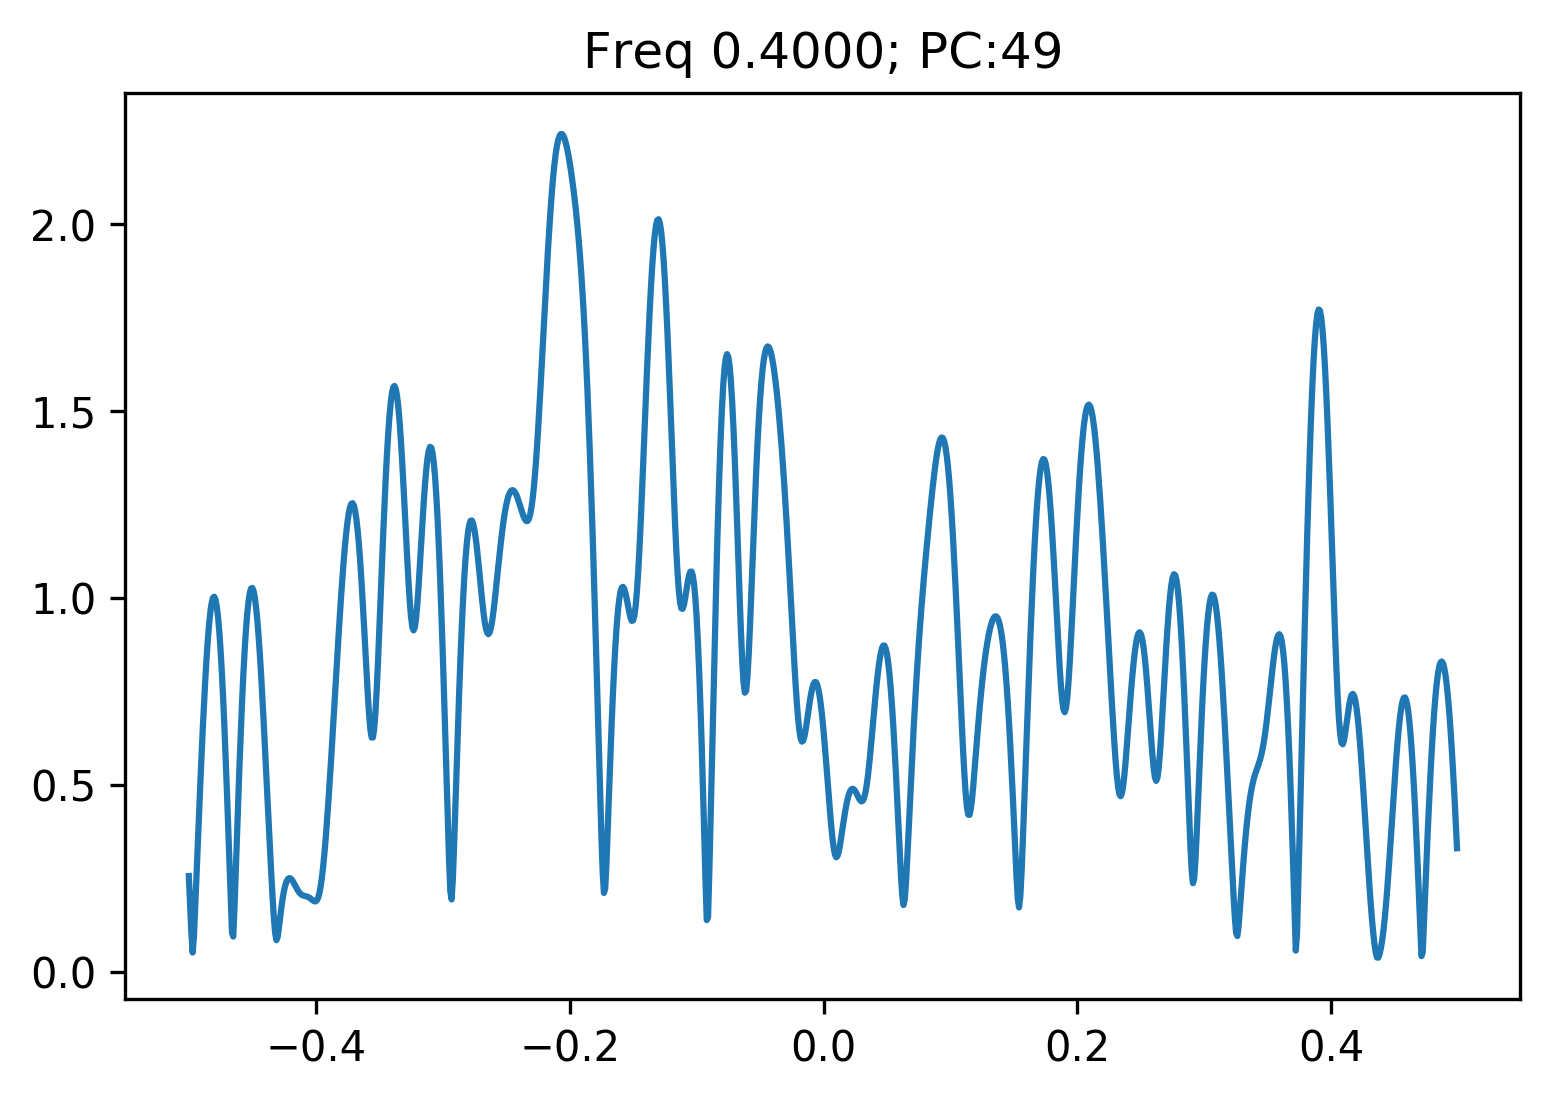

In [171]:
pca_plots(xgrid, target_freq, num_samples, signal_dim, idx_comp=49, fixed_freq_idx=0)

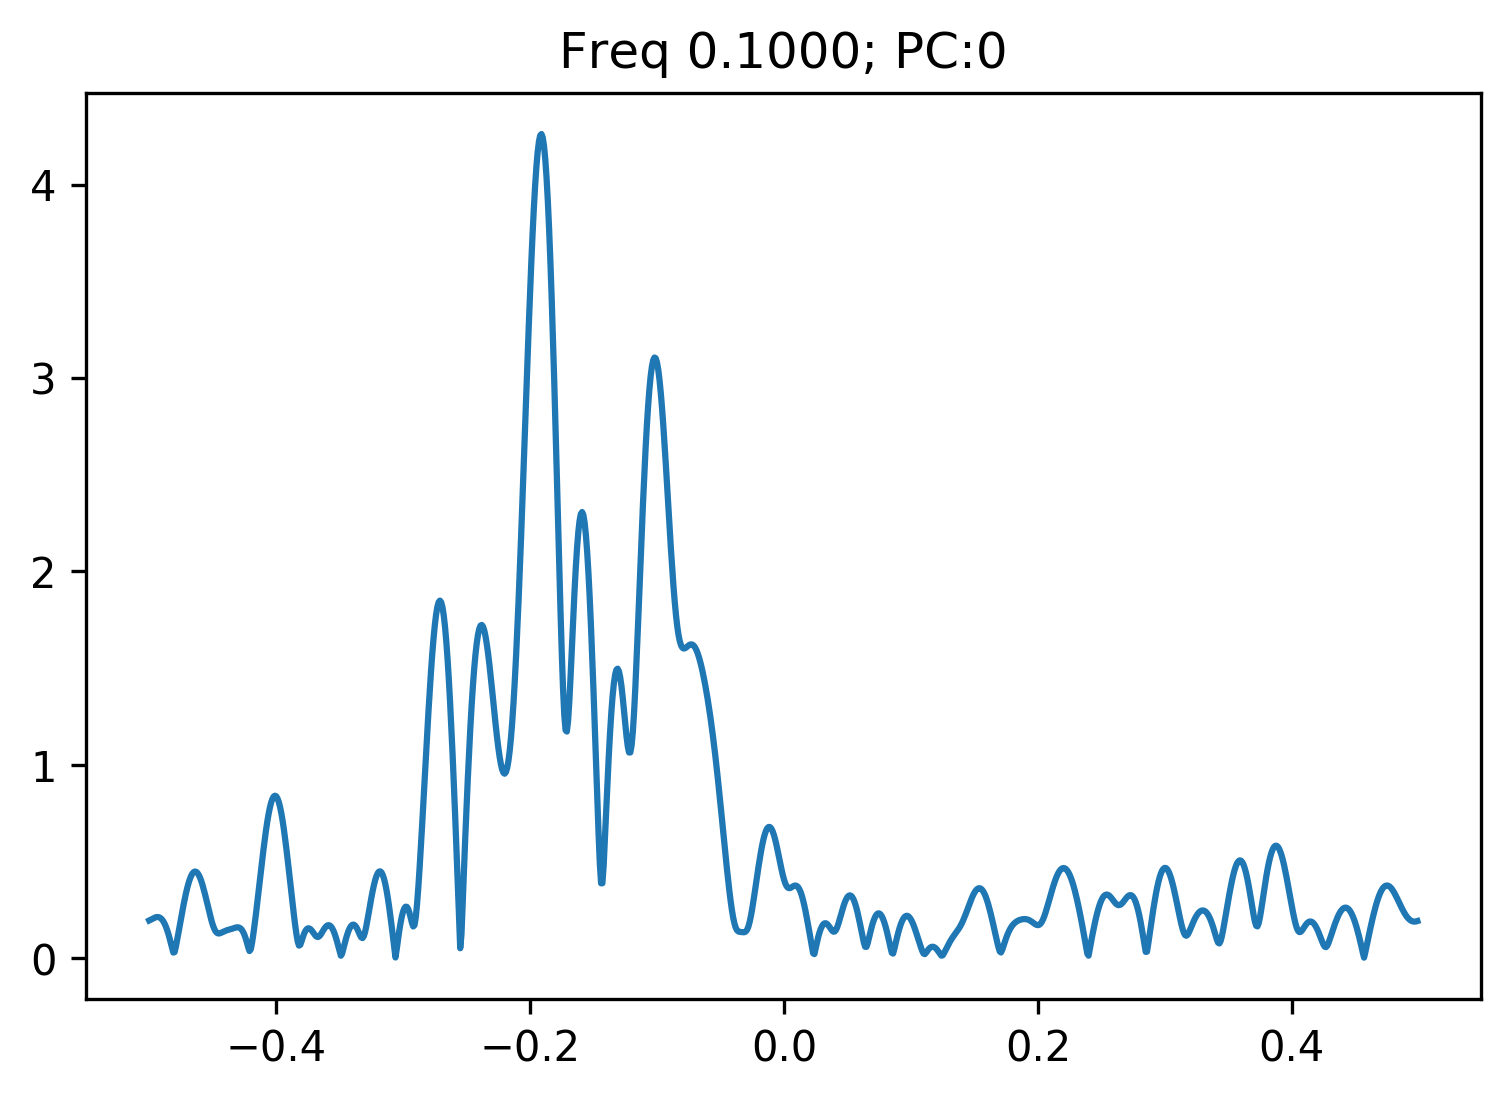

In [168]:
arbitary_row=600
pca_plots(xgrid, target_freq, num_samples, 
          signal_dim, idx_comp=0, fixed_freq_idx=0, arbitary_row=arbitary_row)

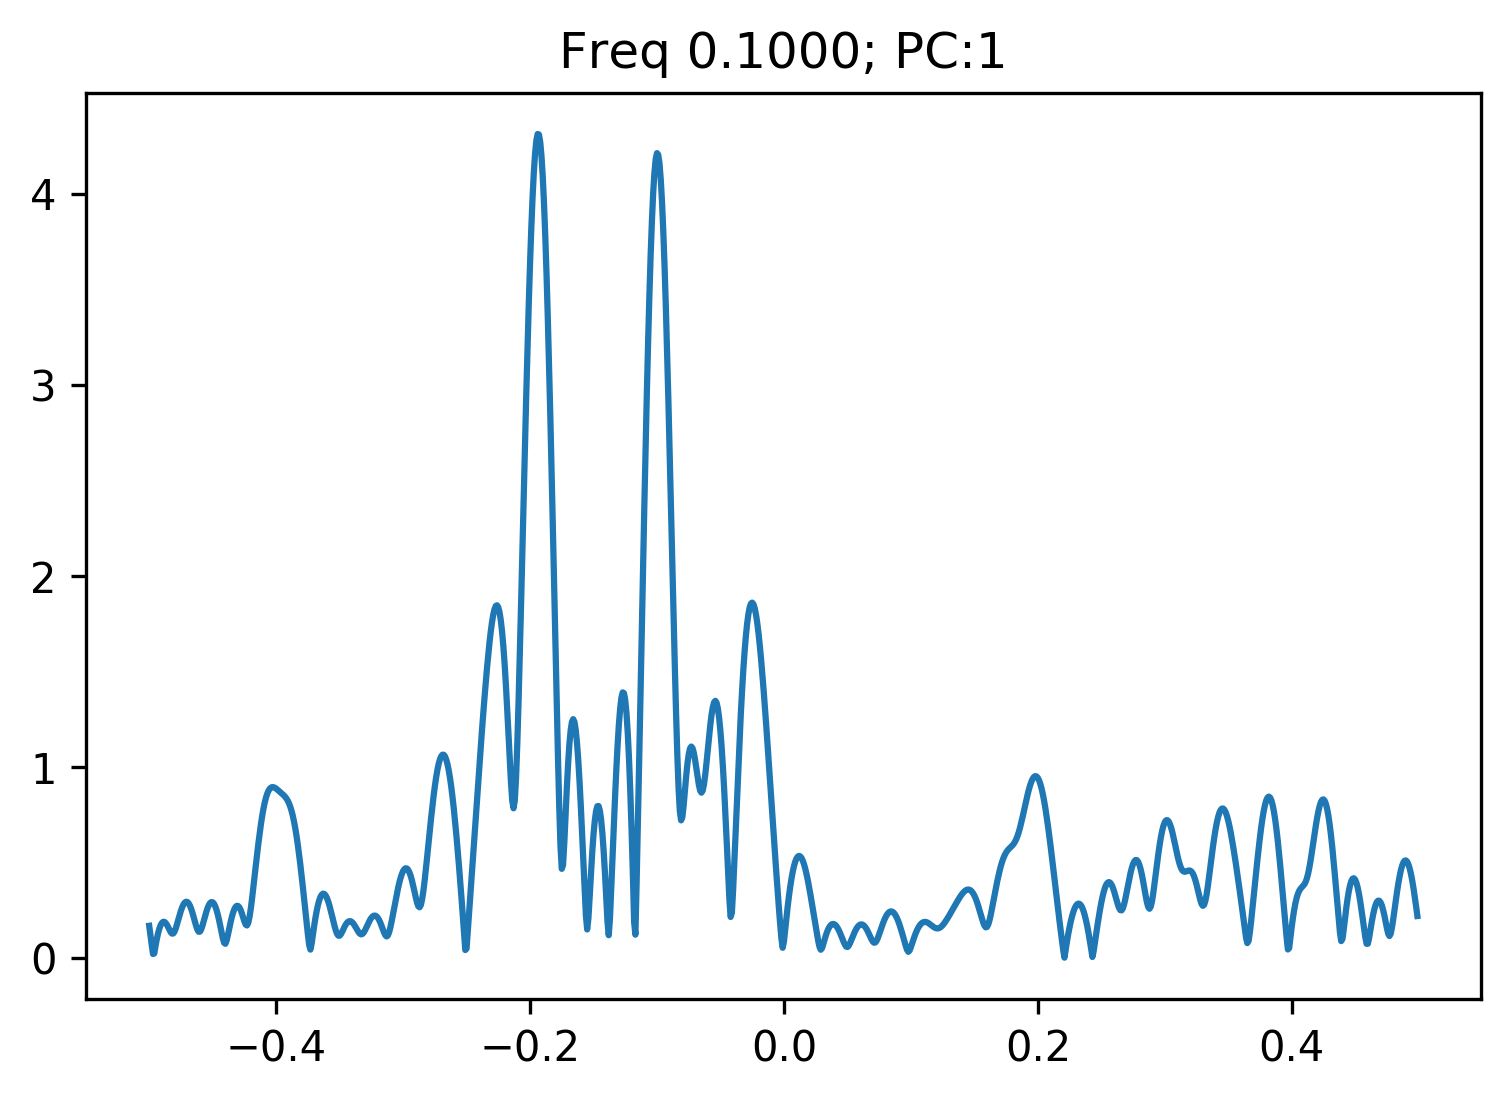

In [169]:
arbitary_row=600
pca_plots(xgrid, target_freq, num_samples, 
          signal_dim, idx_comp=1, 
          fixed_freq_idx=0, 
          arbitary_row=arbitary_row)

# Output figures into PDF

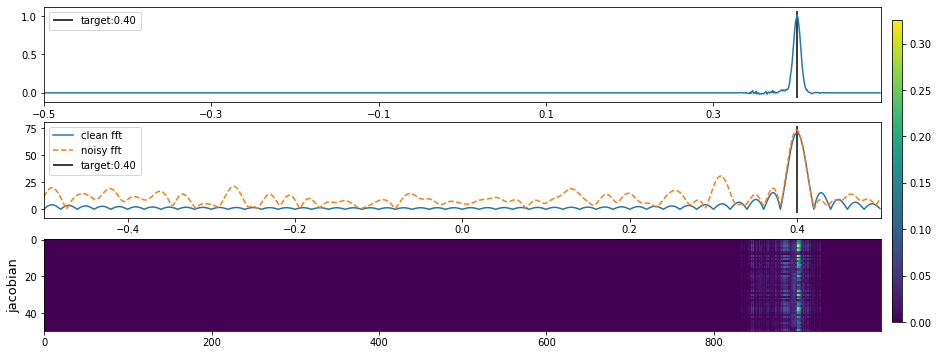

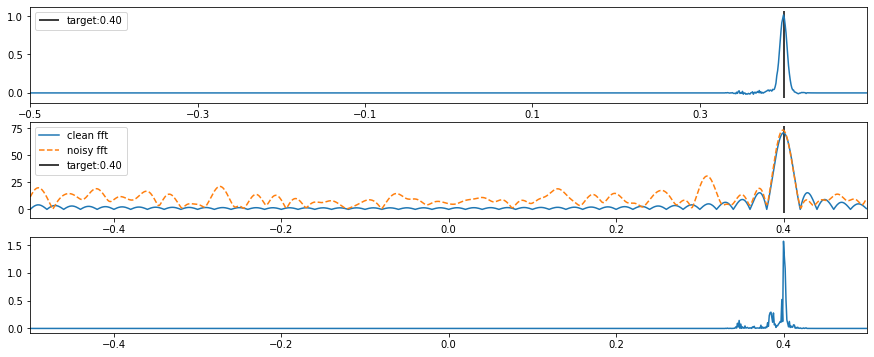

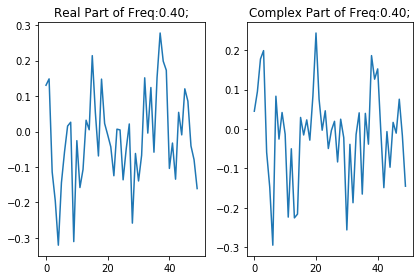

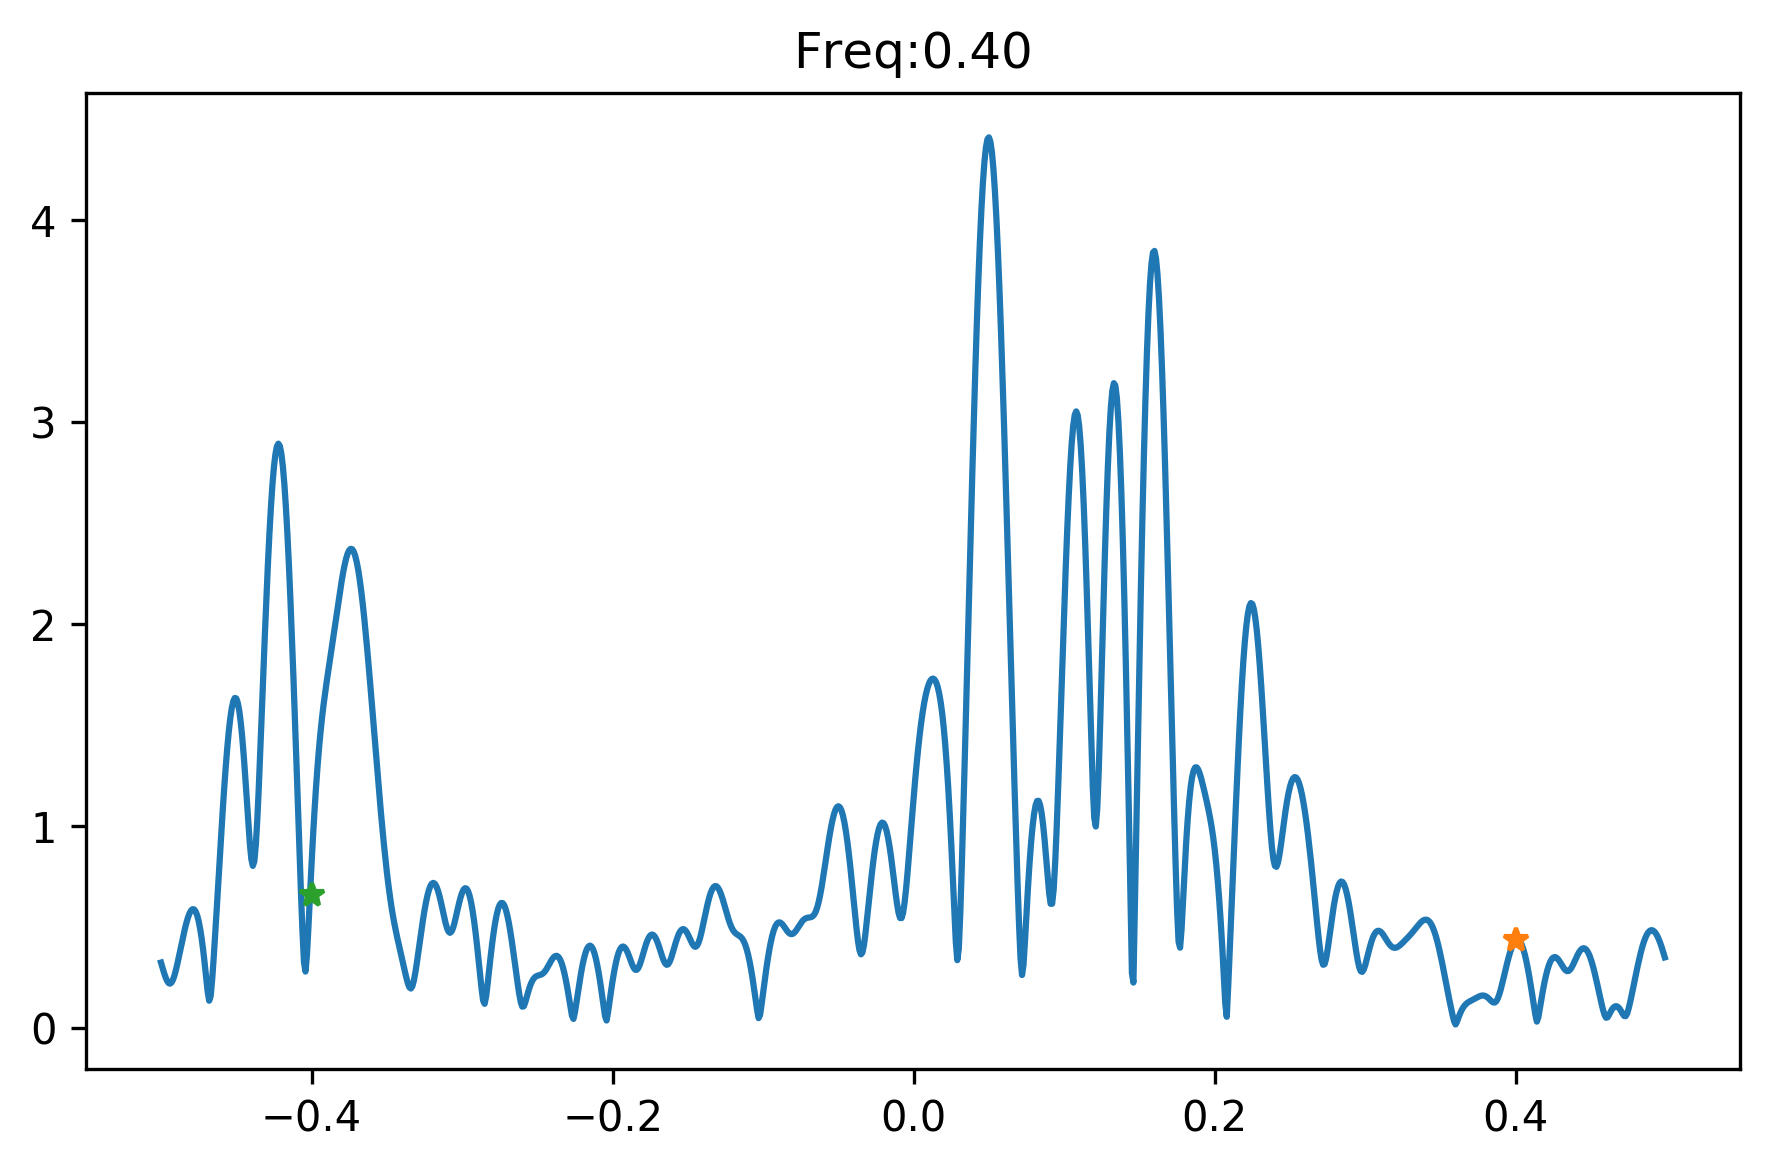

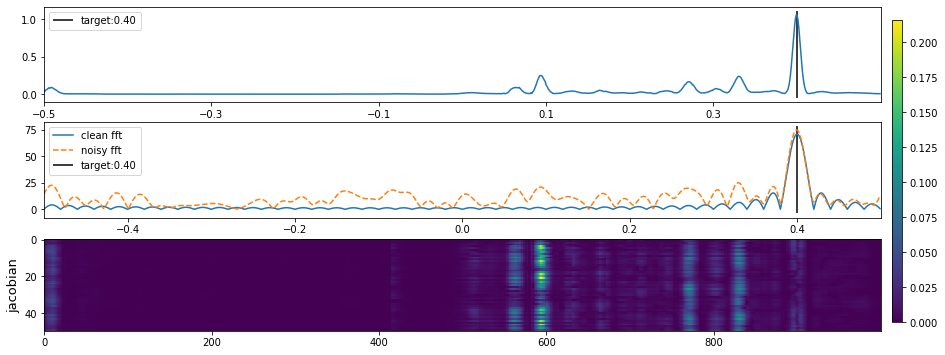

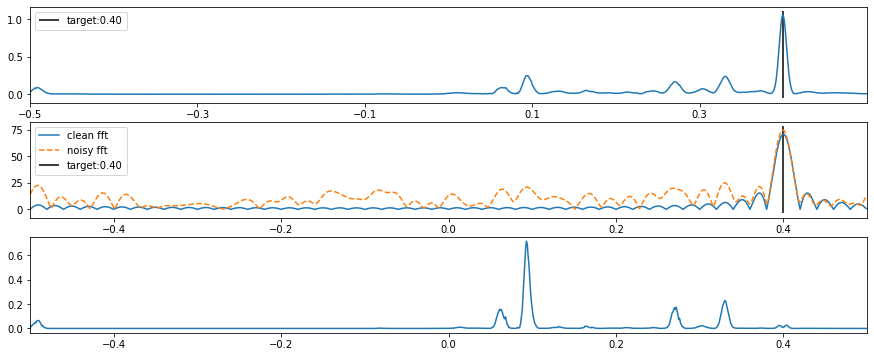

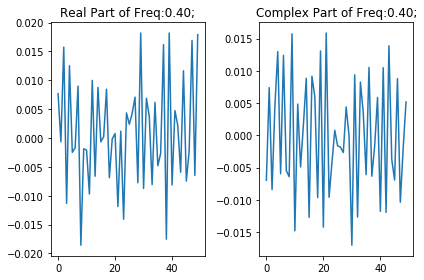

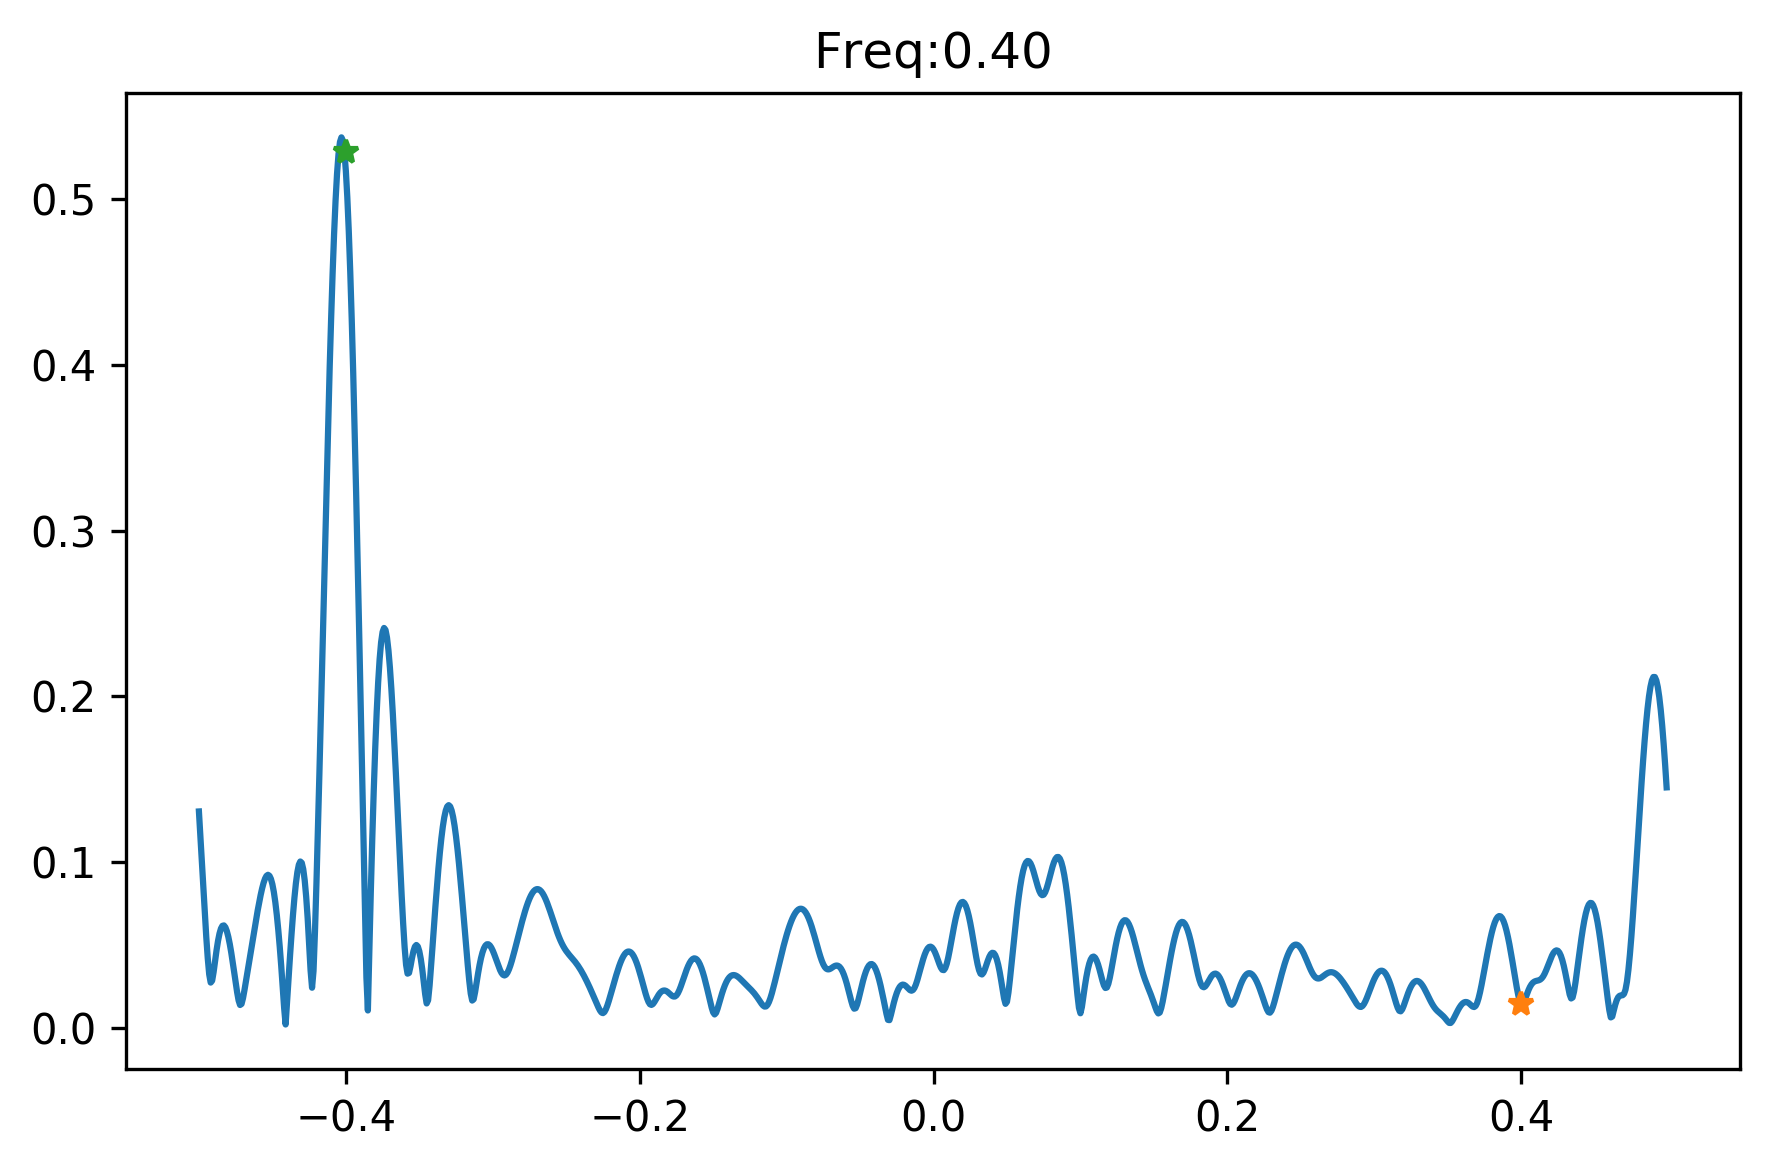

KeyboardInterrupt: 

In [113]:
# hyper parameter setting
num_samples=5
signal_dim=50
min_sep=1.
snr=30
fixed_freq = [0.4] # set None for  random frequency
num_freq=len(fixed_freq)
snr=1
generate_report_plots(num_samples=num_samples,
                      signal_dim=signal_dim,
                      min_sep=min_sep,
                      snr=snr,
                      fixed_freq=fixed_freq,
                      save=True)